# X-Ray Abnormality Detection | CNN

> **MSc in Data Science, AUEB** <br />
> Giogiakas Sotirios ( *p3352204* ) <br />
> Sakkis Panagiotis ( *p3352222* ) 


In [44]:
import os
import random
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc

import tensorflow as tf
from sklearn.utils import shuffle
from keras_adabound import AdaBound
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy

In [2]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [45]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

In [30]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)




def plot_all_metrics(history):
    metrics = [metric for metric in history.history.keys() if not metric.startswith('val_')]
    # Limit the metrics to the first 4
    metrics = metrics[:4]
    num_metrics = len(metrics)

    num_rows = (num_metrics + 1) // 2
    num_cols = 2

    plt.figure(figsize=(12, 4 * num_rows))

    for i, metric in enumerate(metrics):
        row_idx = i // num_cols  # Calculate the row index
        col_idx = i % num_cols   # Calculate the column index

        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(history.epoch, history.history[metric], label=f"Training {metric}")
        if f"val_{metric}" in history.history:
            plt.plot(history.epoch, history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.xlabel('Epochs')
        plt.ylabel(metric.replace("_", " ").capitalize())
        plt.legend()


def plot_training_curves(training_history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['accuracy'])
    plt.plot(training_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'])
    plt.plot(training_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()

In [82]:
# Assuming DATASET_DIR is correctly pointing to the extracted dataset directory
DATASET_DIR = "MURA-v1.1/"

train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [83]:
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[2]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[3]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,patient00002,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,patient00002,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [84]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [85]:
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [86]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,patient00002,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,patient00002,study1_positive,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1


In [88]:
test_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)


test_image_paths["study_type"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[2]
)
test_image_paths["patient"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[3]
)
test_image_paths["study"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
test_image_paths["study_path"] = test_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)


test_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

test_labeled_studies["label"] = test_labeled_studies["label"].map(str)


ref_testset = pd.merge(
    test_image_paths, test_labeled_studies, how="inner", on="study_path"
)

ref_testset

,image_path,study_type,patient,study,study_path,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,patient11186,study1_positive,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1_negative,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,0


### Create a tensorflow input pipeline for the training data

In [10]:
ref_trainset = shuffle(ref_trainset, random_state=SEED)

In [11]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
SEED = 42
rotation_range = 30
batch_size = 128
brightness_range = None #[0.9,1.2]
standardisation = False #if false, just rescale

generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    rescale=1.0 / 255,
    validation_split=0.2
)

trainset = generator.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="training",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

validationset = generator.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=False,
    subset="validation",
    validate_filenames=True,
    workers=4,  # Adjust based on your CPU
    use_multiprocessing=True
)

Found 29447 validated image filenames belonging to 2 classes.
Found 7361 validated image filenames belonging to 2 classes.


In [37]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    rescale=1.0 / 255
)


testset = generator.flow_from_dataframe(
    dataframe=ref_testset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=False,
    validate_filenames=True,
    workers=4,  # Adjust based on your CPU
    use_multiprocessing=True
)

Found 3197 validated image filenames belonging to 2 classes.


### CNN architecture with all study types

We set some metrics definition to check the metrics during training!

In [12]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

In [13]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="cohen_kappa", num_classes=2),
        F1Score(name="f1_score")
    ]

In [126]:
def build_model(
        pooling_type='avg',
        starting_filters=32,
        conv_layers=2,
        conv_strides=(1, 1),
        conv_kernel=(3, 3),
        convs_per_layer=1,
        batch_norm=True,
        dropout_rate=0.1,
        pool_size=(2, 2),
        pool_strides=(2, 2),
        spatial_dropout=None,
        learning_rate = 1e-4,
        kernel_initializer = 'he_uniform',
        dense_units = 128,
        optimizer = 'adam'
    ):


    # create model object
    model = tf.keras.Sequential()

    for i in range(conv_layers):
        current_filters = starting_filters * (2 ** i)
        for conv_number in range(convs_per_layer):
            #adding convolutional layer
            model.add(tf.keras.layers.Conv2D(
                #adding filter
                filters=current_filters,
                # adding filter size or kernel size
                kernel_size=conv_kernel,
                strides=conv_strides,
                padding='same',
                #activation function
                activation='relu',
                name = f"conv_{str(conv_number)}{str(i)}"
            ))

        if batch_norm:
            model.add(
                tf.keras.layers.BatchNormalization(name=f"bn_{str(i)}")
            )

        if spatial_dropout:
            model.add(
                tf.keras.layers.SpatialDropout2D(spatial_dropout, name=f"sp_dropout_{str(i)}")
            )
        
        if pooling_type == 'max':
            # add poolling layer
            model.add(tf.keras.layers.MaxPooling2D(
                pool_size=pool_size,
                strides=pool_strides,
                padding='same',
                name = f"max_pooling_{str(i)}"
            ))
        elif pooling_type == 'avg':
            # add poolling layer
            model.add(tf.keras.layers.AveragePooling2D(
                pool_size=pool_size,
                strides=pool_strides,
                padding='same',
                name = f"avg_pooling_{str(i)}"
            ))


    model.add(tf.keras.layers.Dropout(
        rate=dropout_rate
    ))

    # adding flatten layer
    model.add(tf.keras.layers.Flatten())
    
    # adding dense layer
    model.add(tf.keras.layers.Dense(
        units=dense_units,
        kernel_initializer=kernel_initializer,
        activation='relu'
    ))

    model.add(tf.keras.layers.Dropout(
        rate=dropout_rate
    ))

    # output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        #compilation of model
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate),
                      loss='binary_crossentropy',
                      metrics=[metrics()])
    elif optimizer == 'adabound':
        #compilation of model
        model.compile(optimizer=AdaBound(lr=learning_rate, final_lr=0.1),
                      loss='binary_crossentropy',
                      metrics=[metrics()])

    return model

In [18]:
#define callbacks
early_stopping = EarlyStopping(
    monitor = 'val_loss', 
    patience = 5
)

reduce_lr_plateau = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.1,
    patience = 2,
    min_delta = 0.0001,
    cooldown = 0,
    min_lr = 0
)

### CNN Model-0

In [130]:
cnn_model0 = build_model(
    pooling_type='avg',
    starting_filters=32,
    conv_layers=3,
    convs_per_layer=1,
    learning_rate=1e-4,
    spatial_dropout=0.1,
    dropout_rate = 0.2,
)

In [131]:
EPOCHS = 100
BATCH_SIZE = 128

hs0 = cnn_model0.fit(
    trainset,
    validation_data = validationset, 
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

print('Training.')
print('------------------')
cnn_model0.summary()
filename = 'models/model_0.keras'
cnn_model0.save(filename)
print('>Saved %s' % filename)
# cnn_model_eval = cnn_model.evaluate(test_generator)
# clean_up(model=cnn_model)
# print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

Epoch 1/100
461/461 [==============================] - 290s 626ms/step - loss: 3.4640 - auc: 0.5330 - accuracy: 0.5393 - cohen_kappa: 0.0477 - f1_score: 0.4379 - val_loss: 1.0460 - val_auc: 0.5855 - val_accuracy: 0.5723 - val_cohen_kappa: 0.1213 - val_f1_score: 0.4849 - lr: 1.0000e-04
Epoch 2/100
461/461 [==============================] - 283s 612ms/step - loss: 3.4055 - auc: 0.5367 - accuracy: 0.5422 - cohen_kappa: 0.0527 - f1_score: 0.4396 - val_loss: 3.0755 - val_auc: 0.5787 - val_accuracy: 0.5226 - val_cohen_kappa: 0.0989 - val_f1_score: 0.5362 - lr: 1.0000e-04
Epoch 3/100
461/461 [==============================] - 281s 609ms/step - loss: 3.5758 - auc: 0.5392 - accuracy: 0.5440 - cohen_kappa: 0.0546 - f1_score: 0.4384 - val_loss: 6.2889 - val_auc: 0.5122 - val_accuracy: 0.4046 - val_cohen_kappa: 0.0071 - val_f1_score: 0.5595 - lr: 1.0000e-04
Epoch 4/100
461/461 [==============================] - 288s 624ms/step - loss: 2.8427 - auc: 0.5440 - accuracy: 0.5438 - cohen_kappa: 0.0567 -

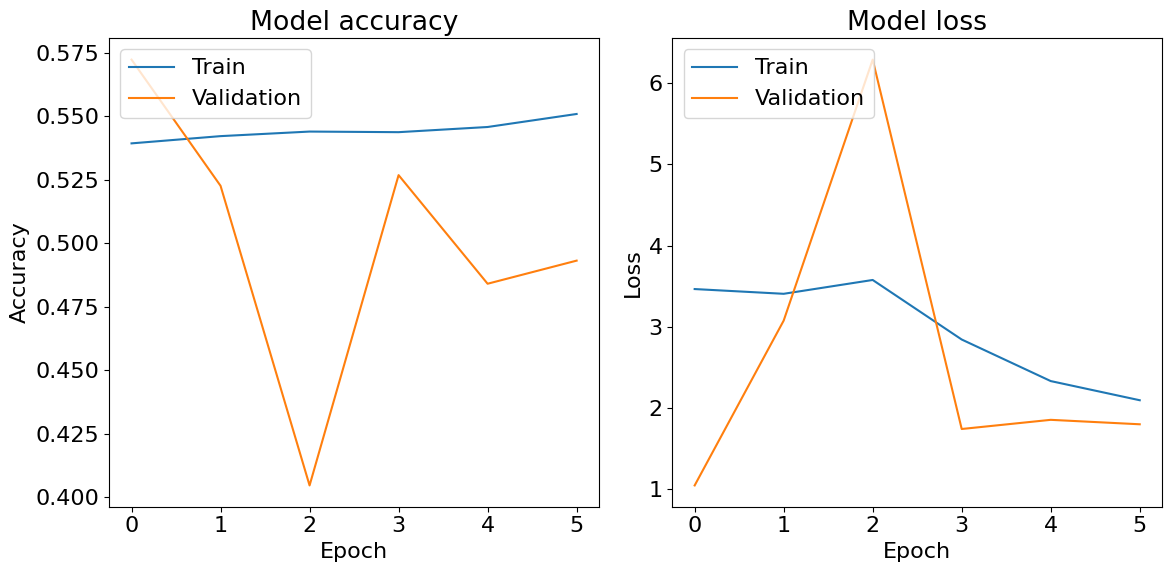

In [133]:
plot_training_curves(hs0)

### CNN Model-1

In [22]:
cnn_model = build_model(
    pooling_type='avg',
    starting_filters=32,
    conv_layers=3,
    convs_per_layer=1
)

In [42]:
EPOCHS = 100
BATCH_SIZE = 128

hs1 = cnn_model.fit(
    trainset,
    validation_data = validationset, 
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

print('Training.')
print('------------------')
cnn_model.summary()
filename = 'models/model_1.keras'
cnn_model.save(filename)
print('>Saved %s' % filename)
# cnn_model_eval = cnn_model.evaluate(test_generator)
# clean_up(model=cnn_model)
# print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

Epoch 1/100
461/461 [==============================] - 418s 905ms/step - loss: 1.0157 - auc: 0.5565 - accuracy: 0.5594 - cohen_kappa: 0.0767 - f1_score: 0.4383 - val_loss: 0.7597 - val_auc: 0.6029 - val_accuracy: 0.5920 - val_cohen_kappa: 0.1454 - val_f1_score: 0.4818 - lr: 1.0000e-13
Epoch 2/100
461/461 [==============================] - 413s 896ms/step - loss: 1.0011 - auc: 0.5650 - accuracy: 0.5650 - cohen_kappa: 0.0867 - f1_score: 0.4419 - val_loss: 0.7530 - val_auc: 0.6017 - val_accuracy: 0.5949 - val_cohen_kappa: 0.1420 - val_f1_score: 0.4692 - lr: 1.0000e-13
Epoch 3/100
461/461 [==============================] - 419s 908ms/step - loss: 1.0126 - auc: 0.5612 - accuracy: 0.5628 - cohen_kappa: 0.0833 - f1_score: 0.4414 - val_loss: 0.7507 - val_auc: 0.6097 - val_accuracy: 0.5946 - val_cohen_kappa: 0.1507 - val_f1_score: 0.4848 - lr: 1.0000e-13
Epoch 4/100
461/461 [==============================] - 410s 889ms/step - loss: 1.0063 - auc: 0.5638 - accuracy: 0.5602 - cohen_kappa: 0.0786 -

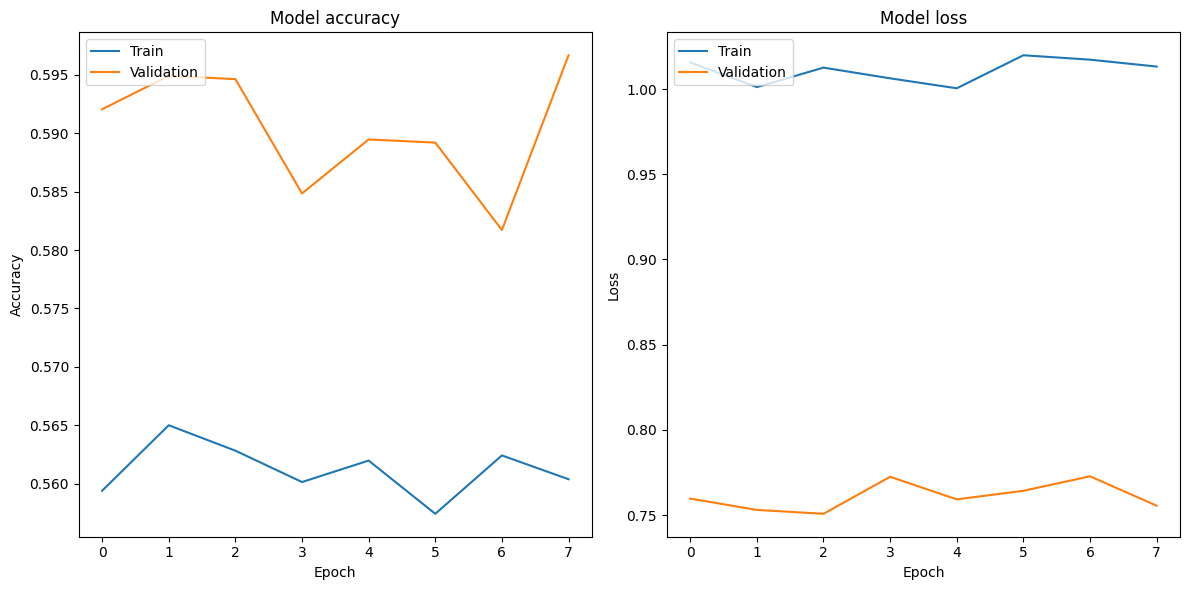

In [43]:
plot_training_curves(hs1)

In [124]:
def plot_history(hs, epochs, metric):
    if metric=='loss': 
                label_y = 'Loss'
    elif metric=='accuracy': 
               label_y = 'Accuracy'
    elif metric=='auc': 
               label_y = 'AUC'
    else : label_y = 'kappa'
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    # x_ticks = np.arange(0, epochs + 1, epochs / 10)
    # x_ticks [0] += 1
    # plt.xticks(x_ticks)
    # plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

def print_results(model_name,epochs,hs,model_eval):
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['cohen_kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['val_cohen_kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))
    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='cohen_kappa')

Train Loss     : 1.01321
Validation Loss: 0.75550
Test Loss      : 0.82574
---
Train AUC     : 0.55950
Validation AUC: 0.60483
Test AUC      : 0.57696
---
Train Accuracy     : 0.56040
Validation Accuracy: 0.59666
Test Accuracy      : 0.55521
---
Train Kappa     : 0.07898
Validation Kappa: 0.14953
Test Kappa      : 0.09993


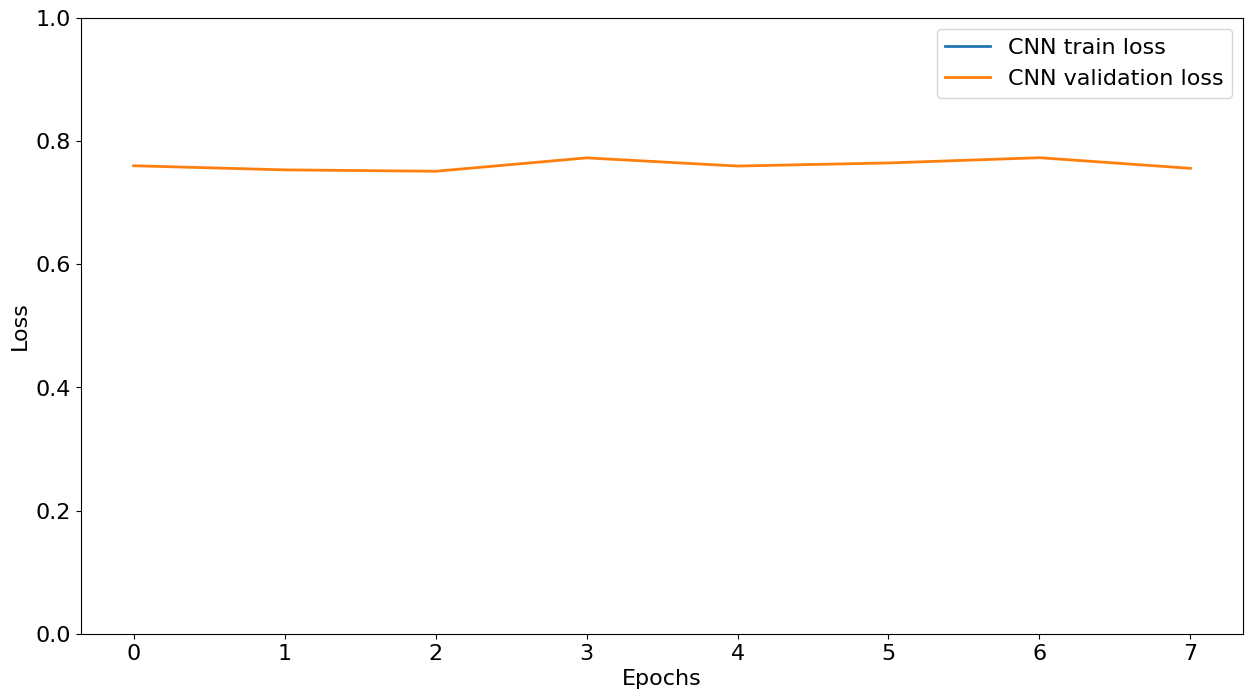

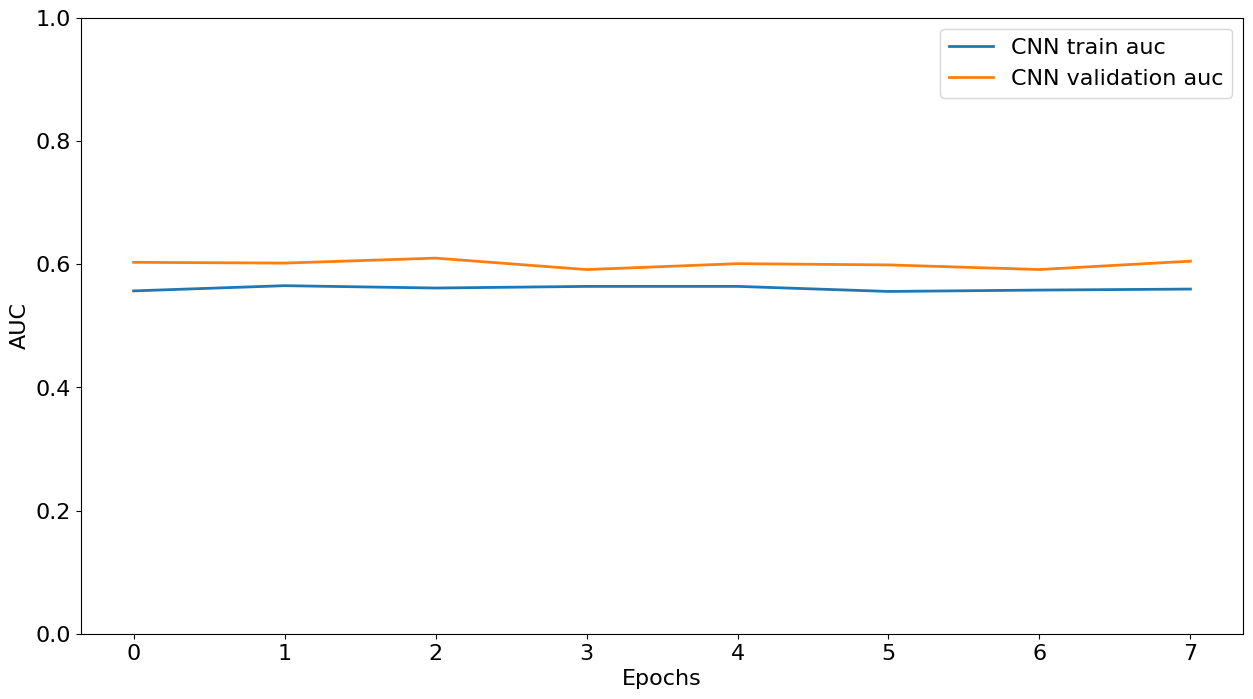

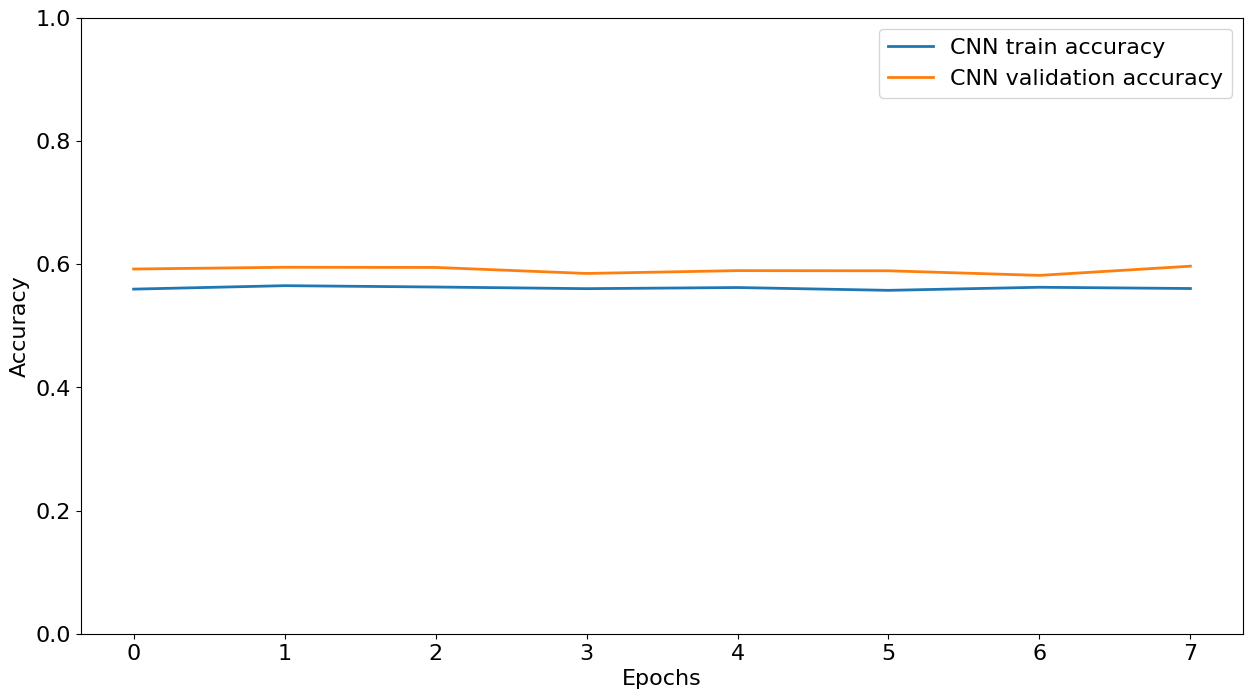

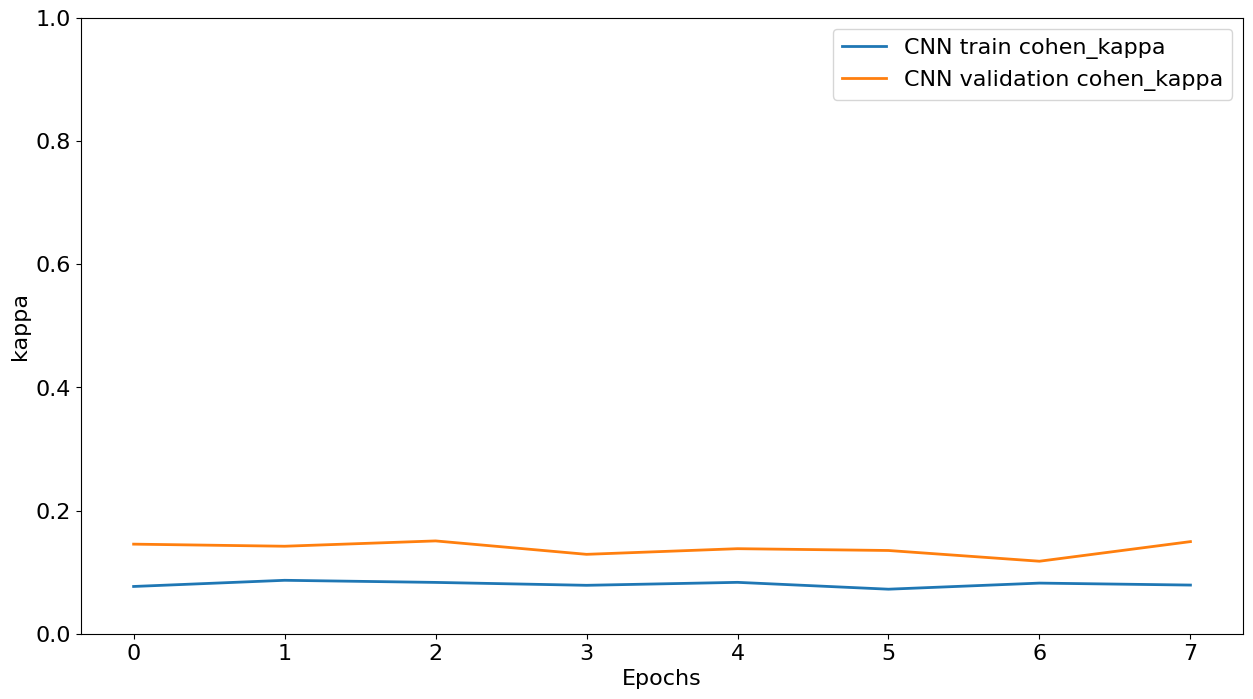

In [59]:
print_results(model_name='CNN',epochs= EPOCHS,hs = hs1, model_eval = cnn_model_eval)

In [49]:
cnn_model_eval = cnn_model.evaluate(testset)
clean_up(model=cnn_model)
# print_results(model_name='CNN',epochs= EPOCHS,hs = hs1, model_eval = cnn_model_eval)

50/50 [==============================] - 23s 463ms/step - loss: 0.8257 - auc: 0.5770 - accuracy: 0.5552 - cohen_kappa: 0.0999 - f1_score: 0.4722
...Finished clean up...
Train Loss     : 1.01321
Validation Loss: 0.75550
Test Loss      : 0.82574
---
Train AUC     : 0.55950
Validation AUC: 0.60483
Test AUC      : 0.57696
---
Train Accuracy     : 0.56040
Validation Accuracy: 0.59666
Test Accuracy      : 0.55521
---


KeyError: 'kappa'

### CNN Model-2

In [61]:
cnn_model = build_model(
    pooling_type='avg',
    starting_filters=32,
    conv_layers=4,
    convs_per_layer=1,
    spatial_dropout=0.1,
    learning_rate=1e-5
)

In [62]:
hs2 = cnn_model.fit(
    trainset,
    validation_data = validationset, 
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    callbacks=[early_stopping]
)

print('Training.')
print('------------------')
cnn_model.summary()
filename = 'models/model_2.keras'
cnn_model.save(filename)
print('>Saved %s' % filename)
# cnn_model_eval = cnn_model.evaluate(test_generator)
# clean_up(model=cnn_model)
# print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

Epoch 1/100
461/461 [==============================] - 386s 832ms/step - loss: 1.1788 - auc: 0.5457 - accuracy: 0.5502 - cohen_kappa: 0.0624 - f1_score: 0.4364 - val_loss: 1.1351 - val_auc: 0.5541 - val_accuracy: 0.4438 - val_cohen_kappa: 0.0444 - val_f1_score: 0.5621
Epoch 2/100
461/461 [==============================] - 348s 754ms/step - loss: 1.0246 - auc: 0.5589 - accuracy: 0.5564 - cohen_kappa: 0.0744 - f1_score: 0.4423 - val_loss: 0.7574 - val_auc: 0.6096 - val_accuracy: 0.6013 - val_cohen_kappa: 0.1368 - val_f1_score: 0.4430
Epoch 3/100
461/461 [==============================] - 295s 639ms/step - loss: 0.9940 - auc: 0.5579 - accuracy: 0.5559 - cohen_kappa: 0.0719 - f1_score: 0.4389 - val_loss: 0.7363 - val_auc: 0.5866 - val_accuracy: 0.5929 - val_cohen_kappa: 0.1076 - val_f1_score: 0.4097
Epoch 4/100
461/461 [==============================] - 297s 643ms/step - loss: 1.0220 - auc: 0.5646 - accuracy: 0.5600 - cohen_kappa: 0.0825 - f1_score: 0.4482 - val_loss: 0.9021 - val_auc: 0.5

/Users/panagiotissakkis/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved models/model_2.h5


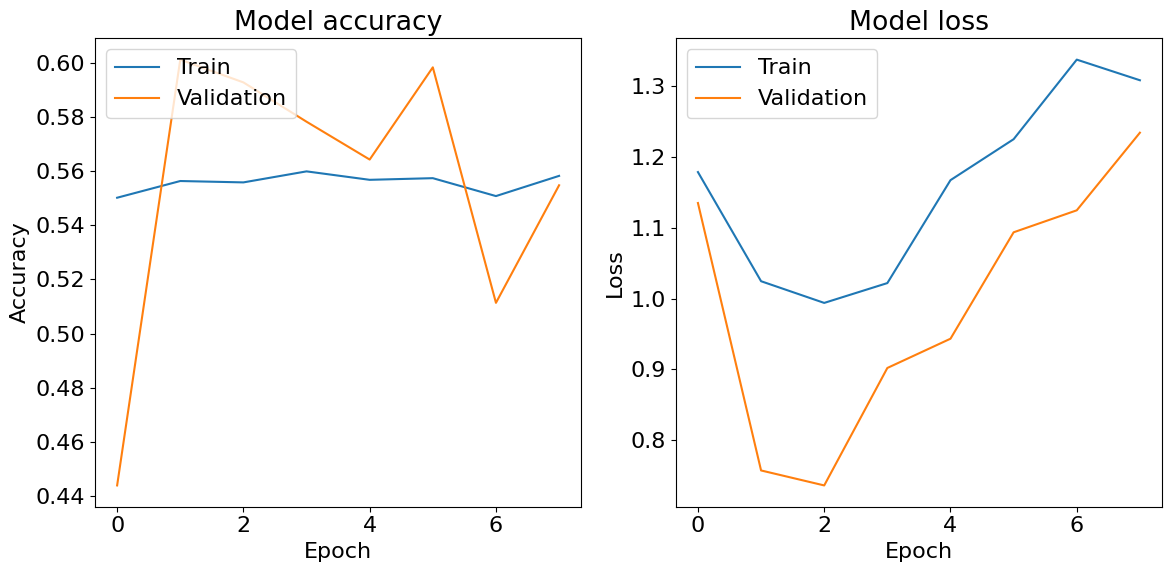

In [65]:
plot_training_curves(hs2)

50/50 [==============================] - 22s 441ms/step - loss: 1.2975 - auc: 0.5192 - accuracy: 0.5299 - cohen_kappa: 0.0418 - f1_score: 0.3817
Train Loss     : 1.30841
Validation Loss: 1.23437
Test Loss      : 1.29750
---
Train AUC     : 0.55784
Validation AUC: 0.51111
Test AUC      : 0.51917
---
Train Accuracy     : 0.55829
Validation Accuracy: 0.55482
Test Accuracy      : 0.52987
---
Train Kappa     : 0.08117
Validation Kappa: 0.01380
Test Kappa      : 0.04183


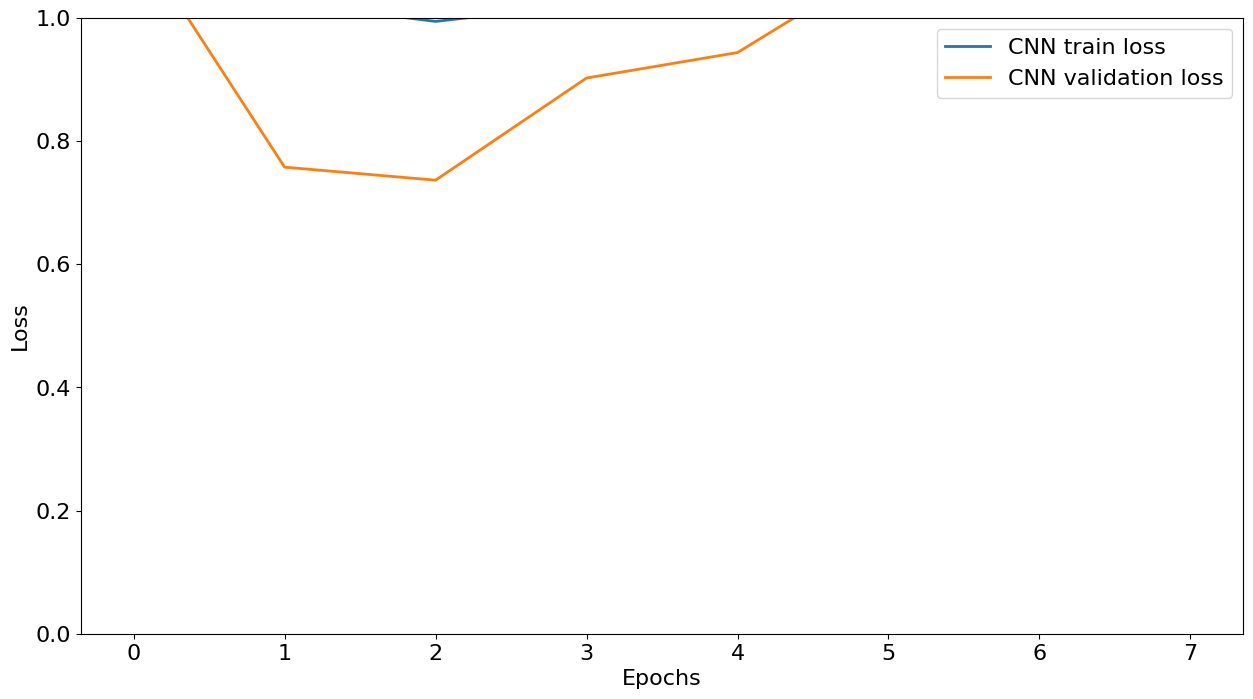

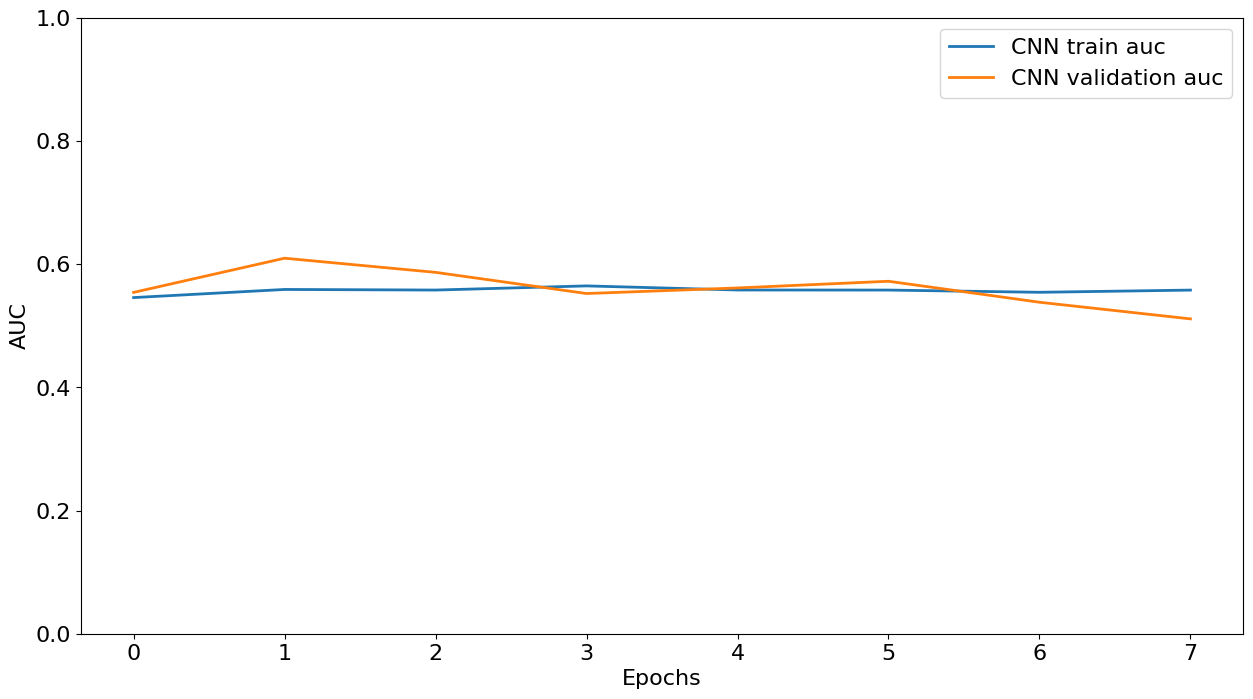

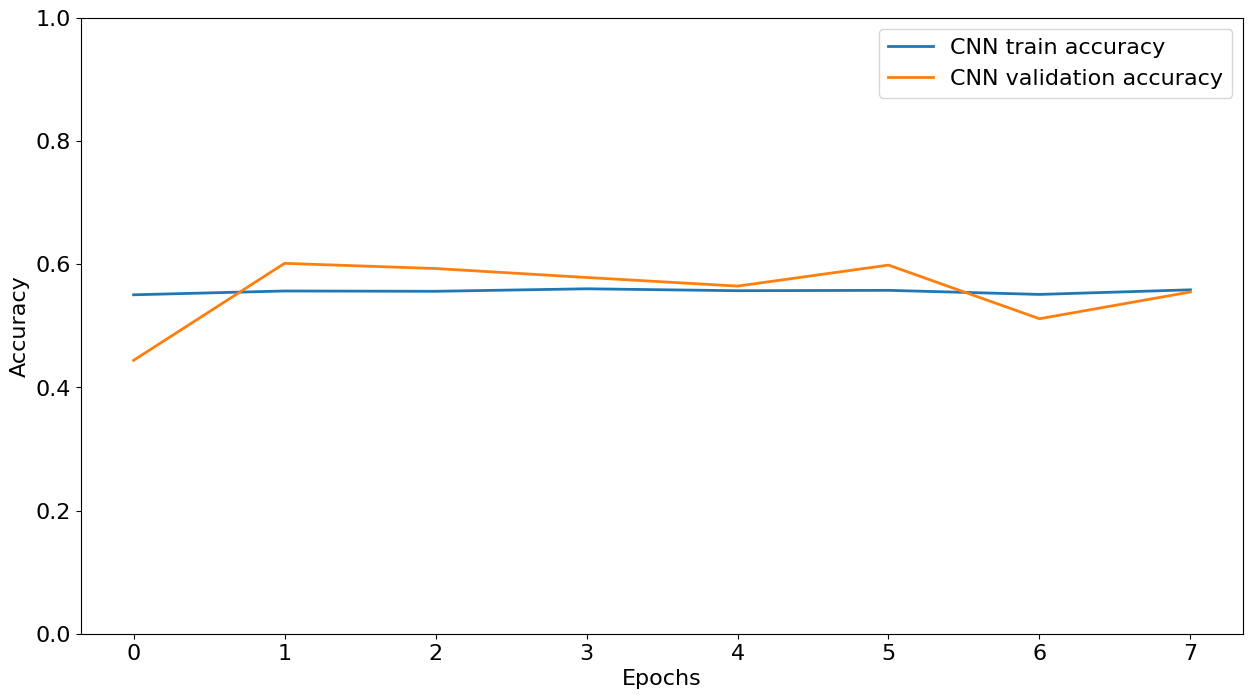

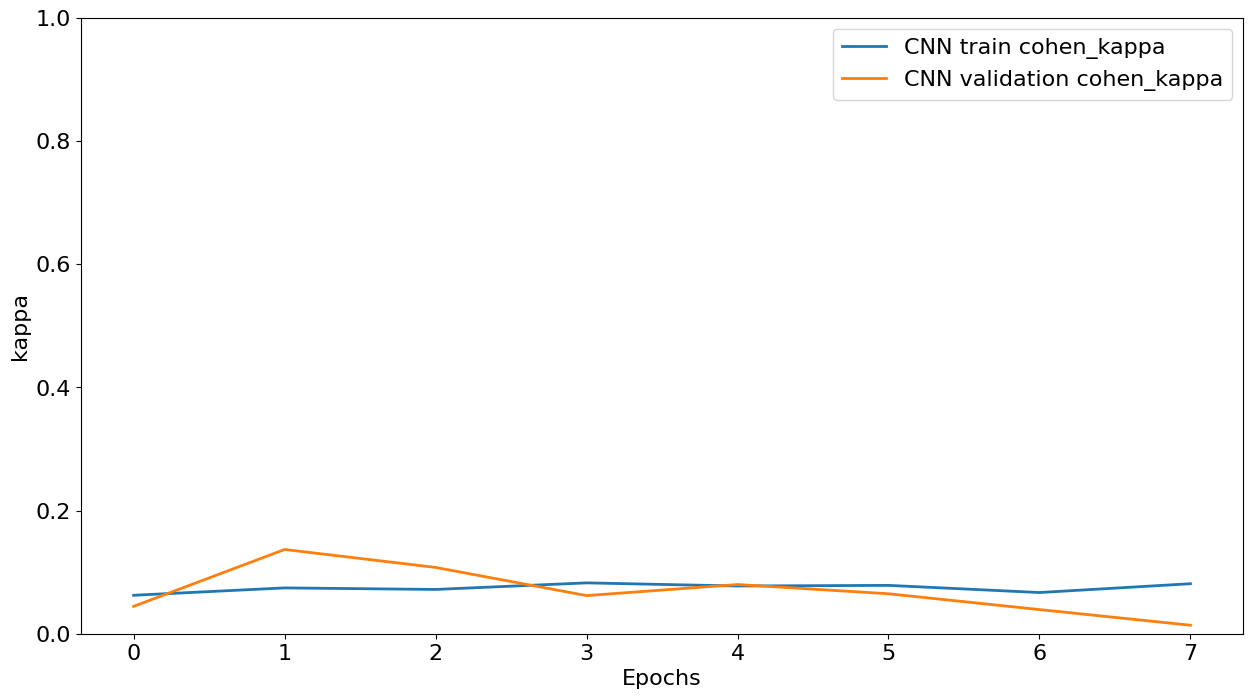

In [67]:
cnn_model_eval = cnn_model.evaluate(testset)
# clean_up(model=cnn_model)
print_results(model_name='CNN',epochs= EPOCHS,hs = hs2, model_eval = cnn_model_eval)

### CNN Model-3

In [70]:
cnn_model = build_model(
    pooling_type='avg',
    starting_filters=32,
    conv_layers=4,
    convs_per_layer=2,
    spatial_dropout=0.1,
    dropout_rate = 0.2,
    learning_rate=1e-3
)

In [71]:
hs3 = cnn_model.fit(
    trainset,
    validation_data = validationset, 
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

print('Training.')
print('------------------')
cnn_model.summary()
filename = 'models/model_3.keras'
cnn_model.save(filename)
print('>Saved %s' % filename)
# cnn_model_eval = cnn_model.evaluate(test_generator)
# clean_up(model=cnn_model)
# print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

Epoch 1/100
461/461 [==============================] - 412s 889ms/step - loss: 11.8411 - auc: 0.5191 - accuracy: 0.5317 - cohen_kappa: 0.0296 - f1_score: 0.4243 - val_loss: 3.8725 - val_auc: 0.5382 - val_accuracy: 0.4093 - val_cohen_kappa: 0.0148 - val_f1_score: 0.5628 - lr: 0.0010
Epoch 2/100
461/461 [==============================] - 410s 888ms/step - loss: 3.1062 - auc: 0.5314 - accuracy: 0.5420 - cohen_kappa: 0.0510 - f1_score: 0.4370 - val_loss: 2.4768 - val_auc: 0.5261 - val_accuracy: 0.4436 - val_cohen_kappa: 0.0275 - val_f1_score: 0.5457 - lr: 0.0010
Epoch 3/100
461/461 [==============================] - 409s 887ms/step - loss: 3.3593 - auc: 0.5280 - accuracy: 0.5365 - cohen_kappa: 0.0392 - f1_score: 0.4296 - val_loss: 2.4455 - val_auc: 0.5766 - val_accuracy: 0.6030 - val_cohen_kappa: 0.0272 - val_f1_score: 0.1506 - lr: 0.0010
Epoch 4/100
461/461 [==============================] - 409s 886ms/step - loss: 3.8069 - auc: 0.5267 - accuracy: 0.5375 - cohen_kappa: 0.0403 - f1_score: 

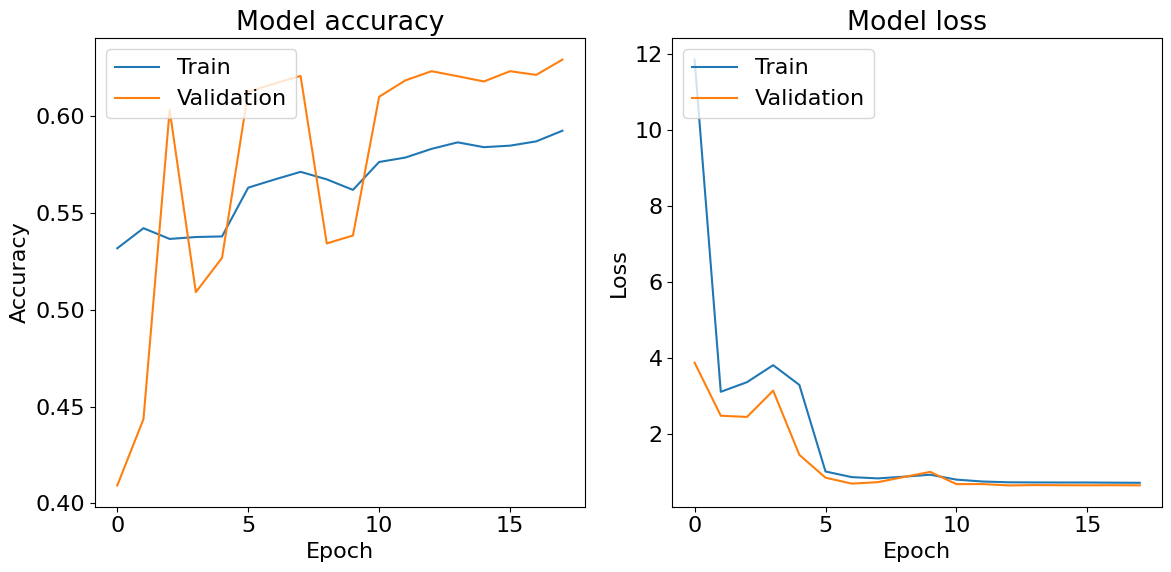

In [72]:
plot_training_curves(hs3)

50/50 [==============================] - 23s 465ms/step - loss: 0.7093 - auc: 0.6308 - accuracy: 0.5702 - cohen_kappa: 0.1208 - f1_score: 0.4010
Train Loss     : 0.71376
Validation Loss: 0.64646
Test Loss      : 0.70933
---
Train AUC     : 0.59878
Validation AUC: 0.64377
Test AUC      : 0.63077
---
Train Accuracy     : 0.59232
Validation Accuracy: 0.62899
Test Accuracy      : 0.57022
---
Train Kappa     : 0.12591
Validation Kappa: 0.16858
Test Kappa      : 0.12077


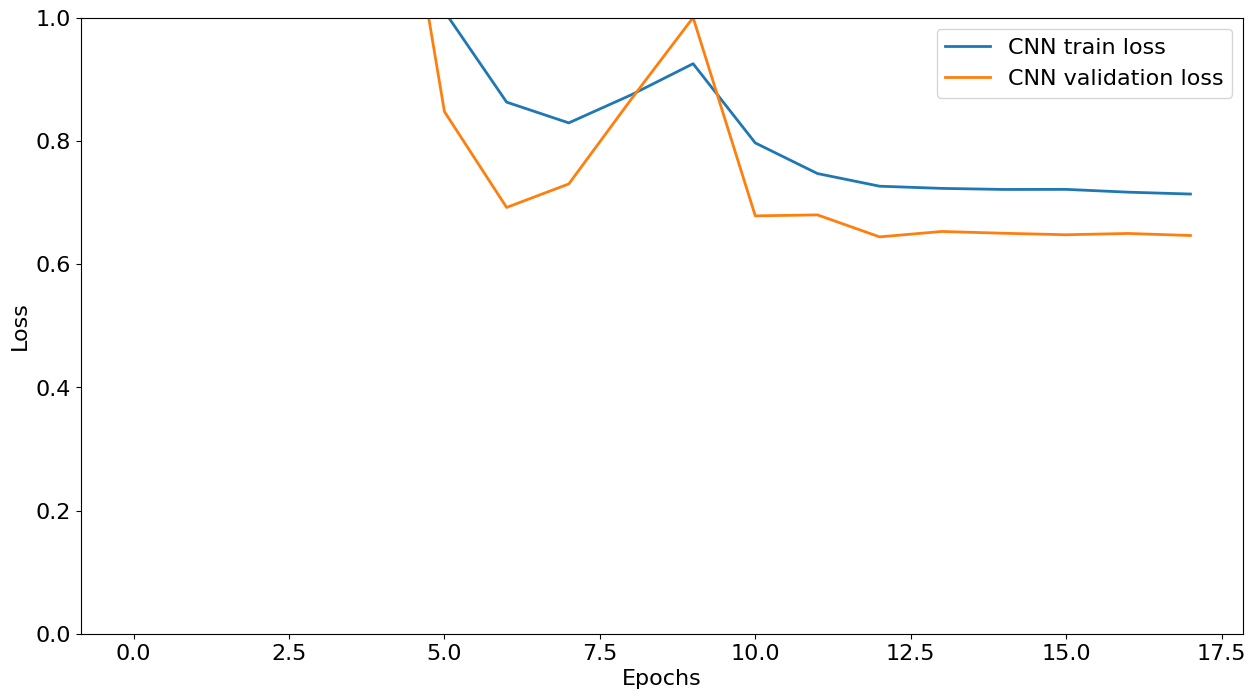

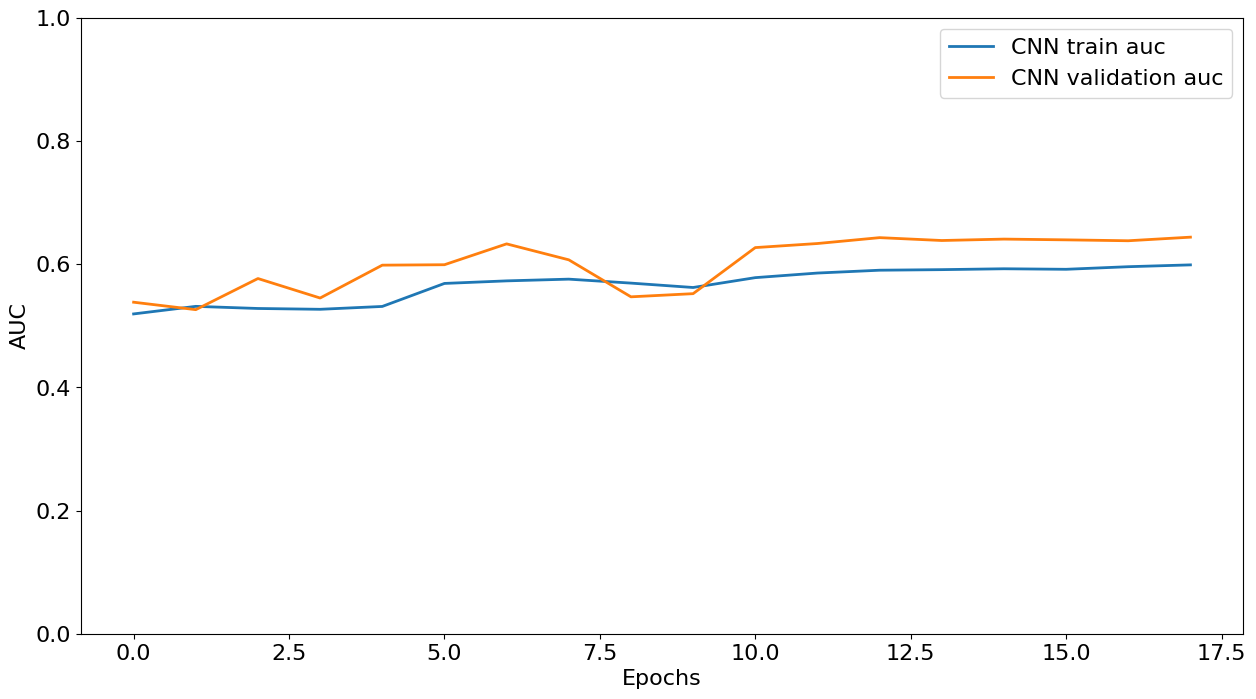

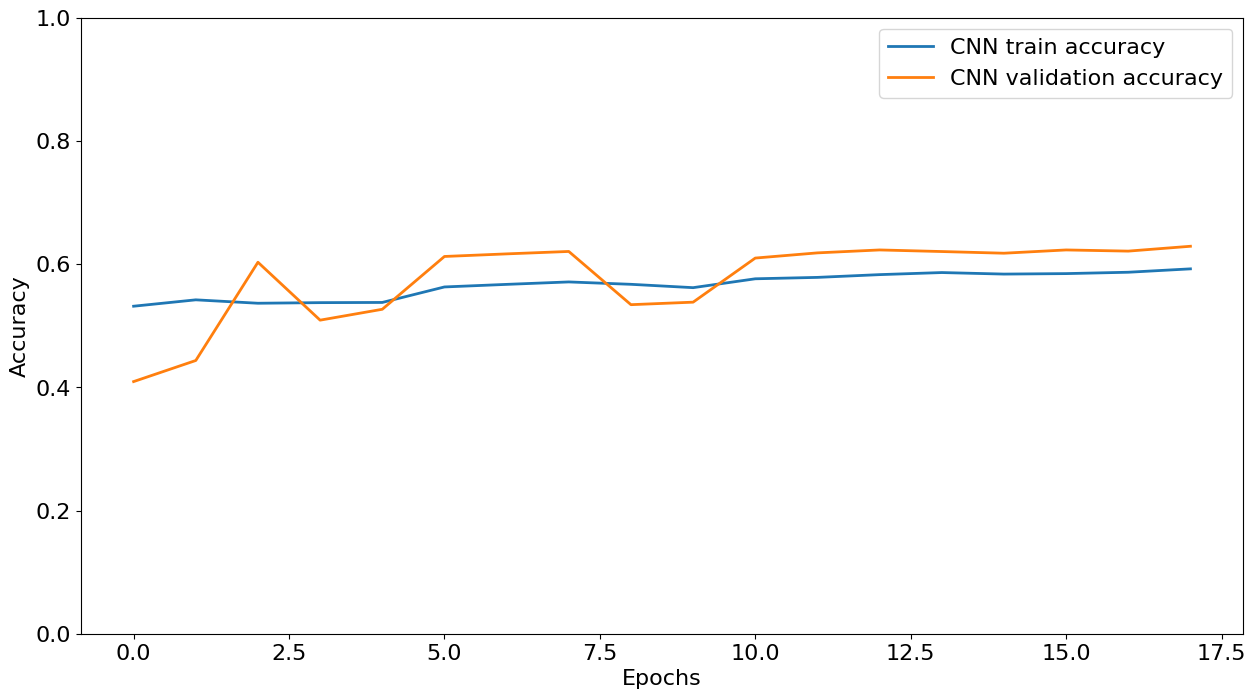

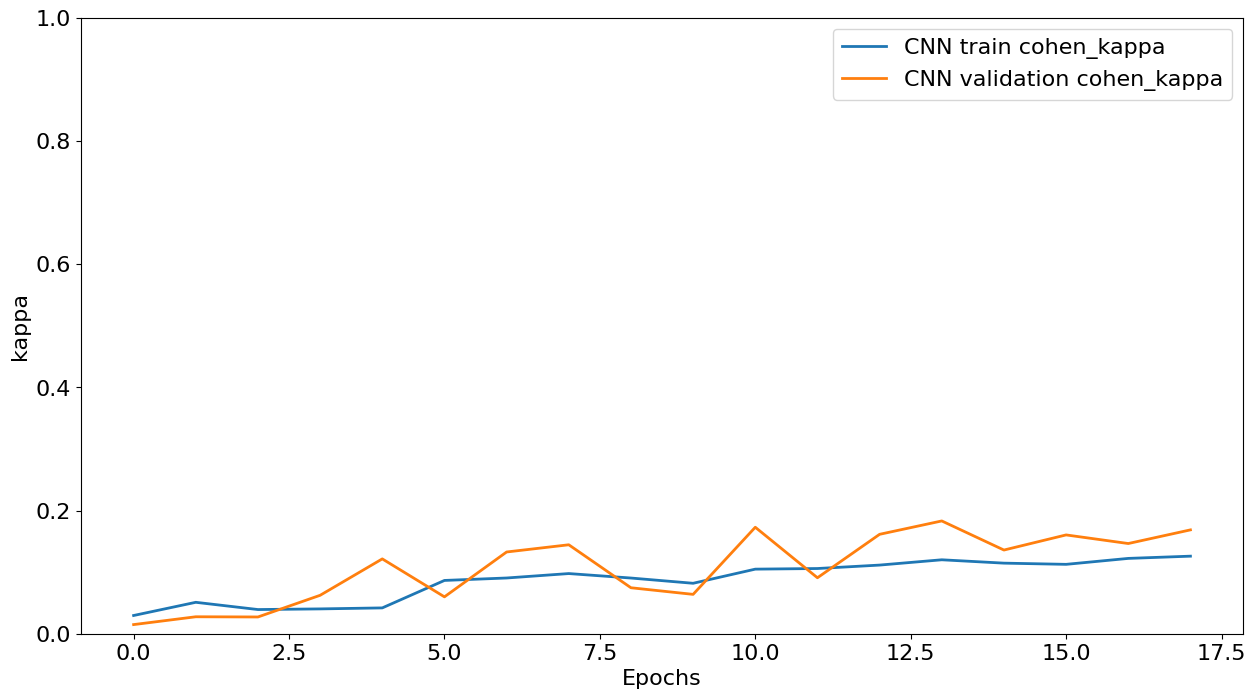

In [73]:
cnn_model_eval = cnn_model.evaluate(testset)
# clean_up(model=cnn_model)
print_results(model_name='CNN',epochs= EPOCHS, hs = hs3, model_eval = cnn_model_eval)

## Per Body Part

### XR_SHOULDER

In [91]:
trainset_shoulder = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="training",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

validset_shoulder = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="validation",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

testset_shoulder = generator.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=False,
    validate_filenames=True,
    workers=4,  # Adjust based on your CPU
    use_multiprocessing=True
)

Found 6704 validated image filenames belonging to 2 classes.


Found 1675 validated image filenames belonging to 2 classes.
Found 563 validated image filenames belonging to 2 classes.


In [92]:
model_shouder = build_model(
    pooling_type='avg',
    starting_filters=32,
    conv_layers=4,
    convs_per_layer=2,
    spatial_dropout=0.1,
    dropout_rate = 0.2,
    learning_rate=1e-3
)

In [93]:
hs_sh = model_shouder.fit(
    trainset_shoulder,
    validation_data = validset_shoulder, 
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

print('Training.')
print('------------------')
cnn_model.summary()
filename = 'models/model_shoulder.keras'
cnn_model.save(filename)
print('>Saved %s' % filename)


Epoch 1/100
105/105 [==============================] - 101s 938ms/step - loss: 32.4004 - auc: 0.5155 - accuracy: 0.5442 - cohen_kappa: 0.0305 - f1_score: 0.3968 - val_loss: 15.1776 - val_auc: 0.5563 - val_accuracy: 0.1570 - val_cohen_kappa: 0.0090 - val_f1_score: 0.2147 - lr: 0.0010
Epoch 2/100
105/105 [==============================] - 95s 899ms/step - loss: 7.7954 - auc: 0.5133 - accuracy: 0.5349 - cohen_kappa: 0.0151 - f1_score: 0.3915 - val_loss: 4.2186 - val_auc: 0.5468 - val_accuracy: 0.2203 - val_cohen_kappa: 0.0041 - val_f1_score: 0.3205 - lr: 0.0010
Epoch 3/100
105/105 [==============================] - 97s 924ms/step - loss: 5.2861 - auc: 0.5327 - accuracy: 0.5492 - cohen_kappa: 0.0456 - f1_score: 0.4105 - val_loss: 0.7601 - val_auc: 0.5260 - val_accuracy: 0.9445 - val_cohen_kappa: 0.0195 - val_f1_score: 0.9714 - lr: 0.0010
Epoch 4/100
105/105 [==============================] - 98s 928ms/step - loss: 6.2467 - auc: 0.5154 - accuracy: 0.5428 - cohen_kappa: 0.0319 - f1_score: 0.

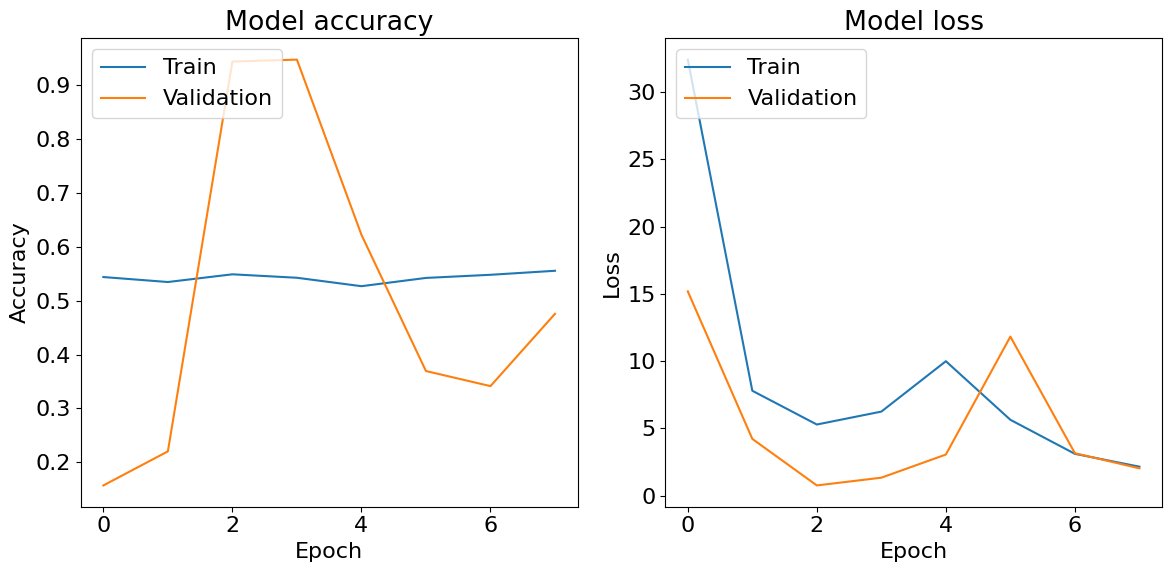

In [94]:
plot_training_curves(hs_sh)

9/9 [==============================] - 4s 450ms/step - loss: 1.6508 - auc: 0.5330 - accuracy: 0.5329 - cohen_kappa: 0.0632 - f1_score: 0.4729
...Finished clean up...
Train Loss     : 2.15329
Validation Loss: 2.03114
Test Loss      : 1.65084
---
Train AUC     : 0.54823
Validation AUC: 0.63447
Test AUC      : 0.53297
---
Train Accuracy     : 0.55579
Validation Accuracy: 0.47582
Test Accuracy      : 0.53286
---
Train Kappa     : 0.05301
Validation Kappa: 0.02851
Test Kappa      : 0.06322


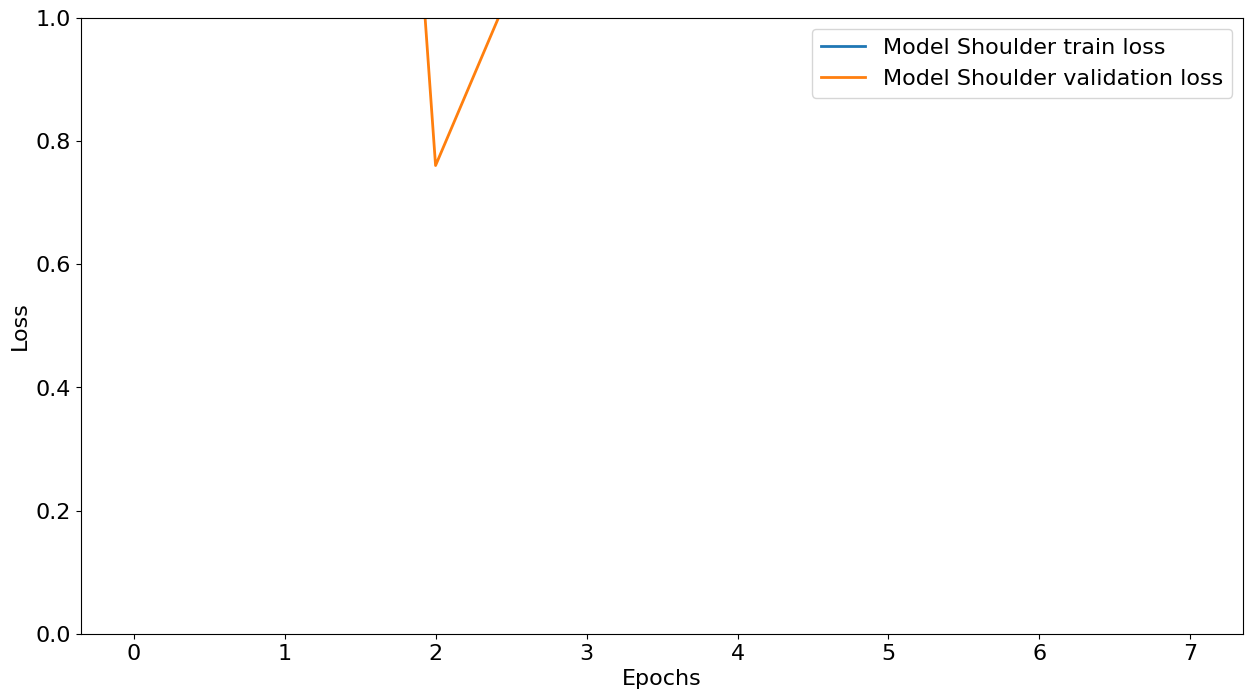

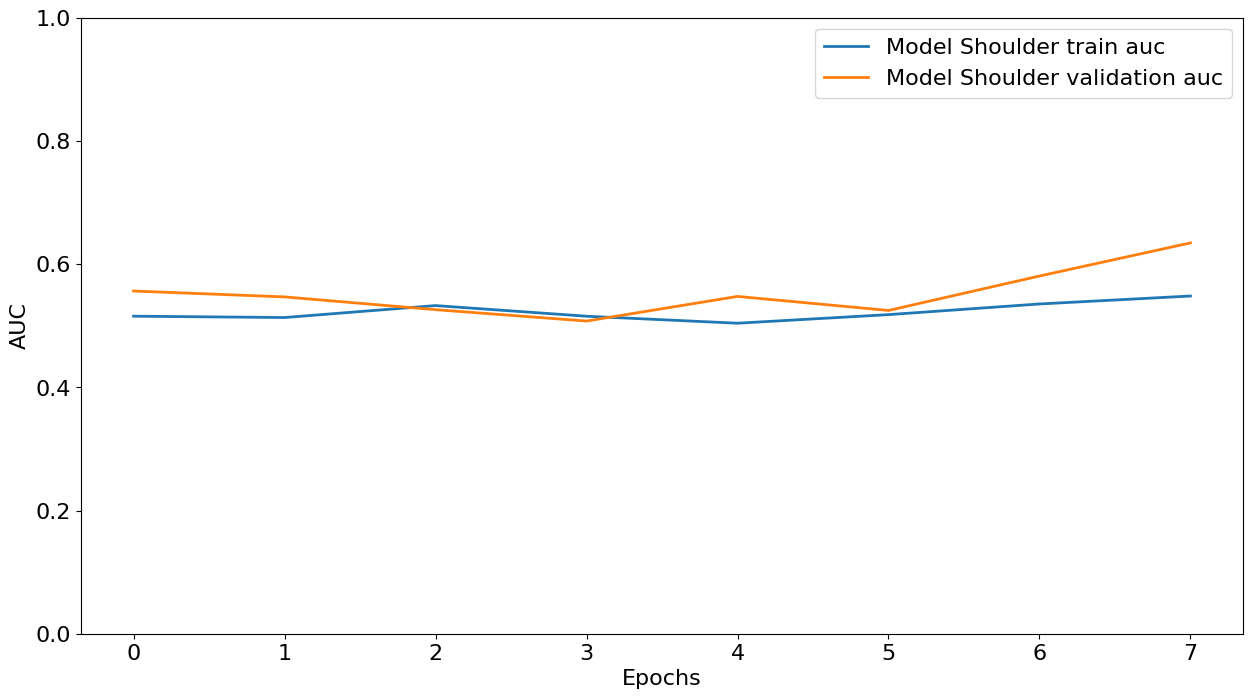

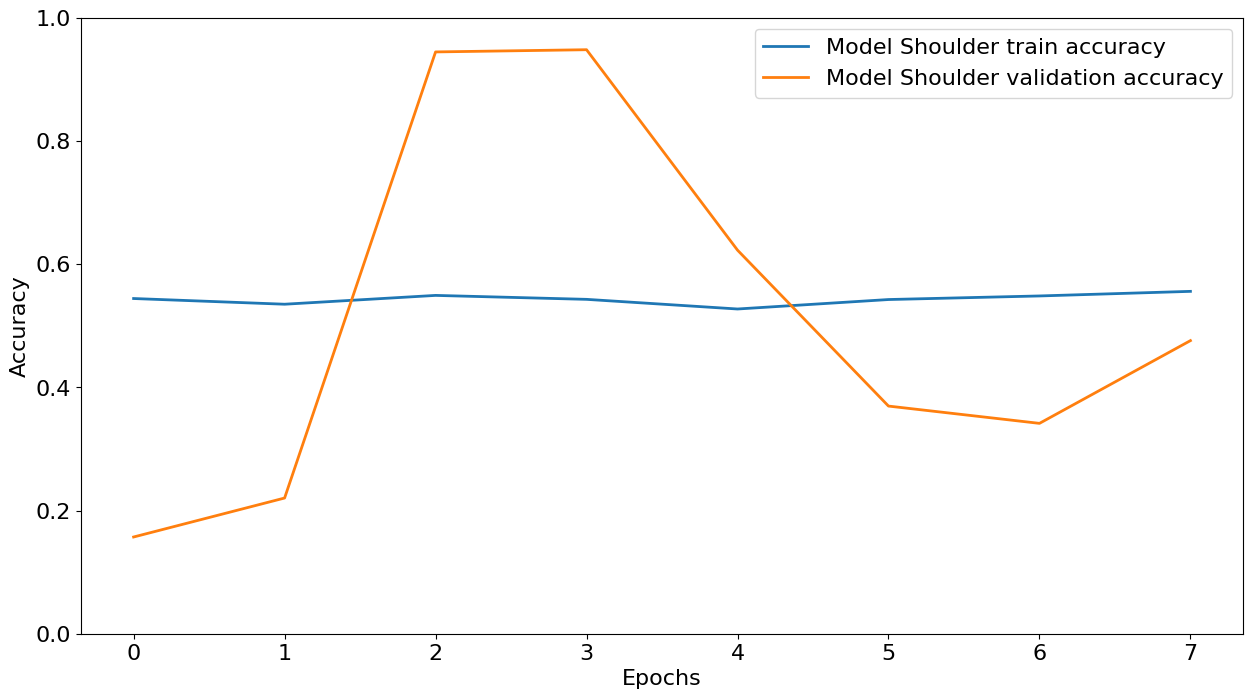

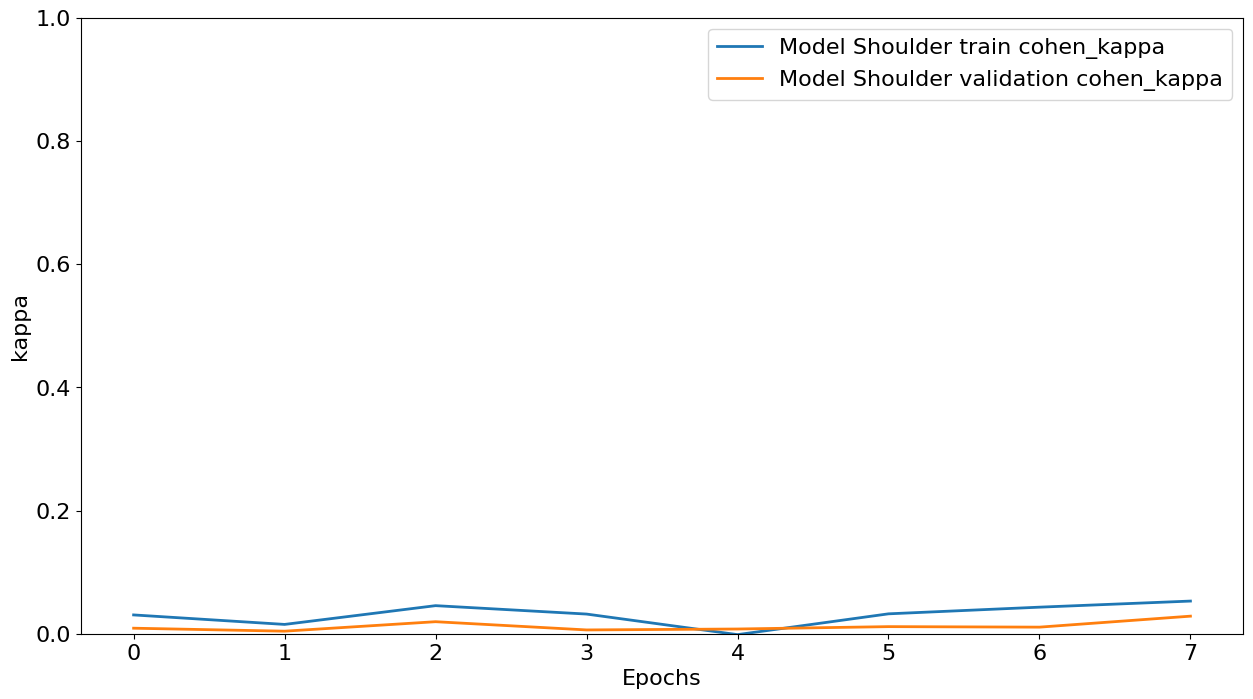

In [95]:
cnn_model_eval = model_shouder.evaluate(testset_shoulder)
clean_up(model=model_shouder)
print_results(model_name='Model Shoulder',epochs= EPOCHS, hs = hs_sh, model_eval = cnn_model_eval)

### XR_ELBOW

In [98]:
trainset_elbow = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="training",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

validset_elbow = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="validation",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

testset_elbow = generator.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=False,
    validate_filenames=True,
    workers=4,  # Adjust based on your CPU
    use_multiprocessing=True
)

Found 3945 validated image filenames belonging to 2 classes.
Found 986 validated image filenames belonging to 2 classes.
Found 465 validated image filenames belonging to 2 classes.


In [99]:
model = build_model(
    pooling_type='avg',
    starting_filters=32,
    conv_layers=4,
    convs_per_layer=2,
    spatial_dropout=0.1,
    dropout_rate = 0.2,
    learning_rate=1e-3
)

In [100]:
hs_elb = model.fit(
    trainset_elbow,
    validation_data = validset_elbow, 
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

print('Training.')
print('------------------')
model.summary()
filename = 'models/model_elbow.keras'
model.save(filename)
print('>Saved %s' % filename)

Epoch 1/100
62/62 [==============================] - 62s 964ms/step - loss: 36.3485 - auc: 0.5275 - accuracy: 0.6292 - cohen_kappa: 0.0527 - f1_score: 0.3056 - val_loss: 97.4876 - val_auc: 0.5021 - val_accuracy: 0.0254 - val_cohen_kappa: 1.3930e-04 - val_f1_score: 0.0062 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - 58s 924ms/step - loss: 33.9710 - auc: 0.5348 - accuracy: 0.6373 - cohen_kappa: 0.0706 - f1_score: 0.3176 - val_loss: 3.1245 - val_auc: 0.4984 - val_accuracy: 0.9757 - val_cohen_kappa: -0.0037 - val_f1_score: 0.9877 - lr: 0.0010
Epoch 3/100
62/62 [==============================] - 58s 931ms/step - loss: 17.5894 - auc: 0.5065 - accuracy: 0.6223 - cohen_kappa: 0.0169 - f1_score: 0.2717 - val_loss: 1.7517 - val_auc: 0.4959 - val_accuracy: 0.9716 - val_cohen_kappa: -0.0097 - val_f1_score: 0.9856 - lr: 0.0010
Epoch 4/100
62/62 [==============================] - 58s 926ms/step - loss: 15.5474 - auc: 0.5182 - accuracy: 0.6299 - cohen_kappa: 0.0367 - f1_score: 0.

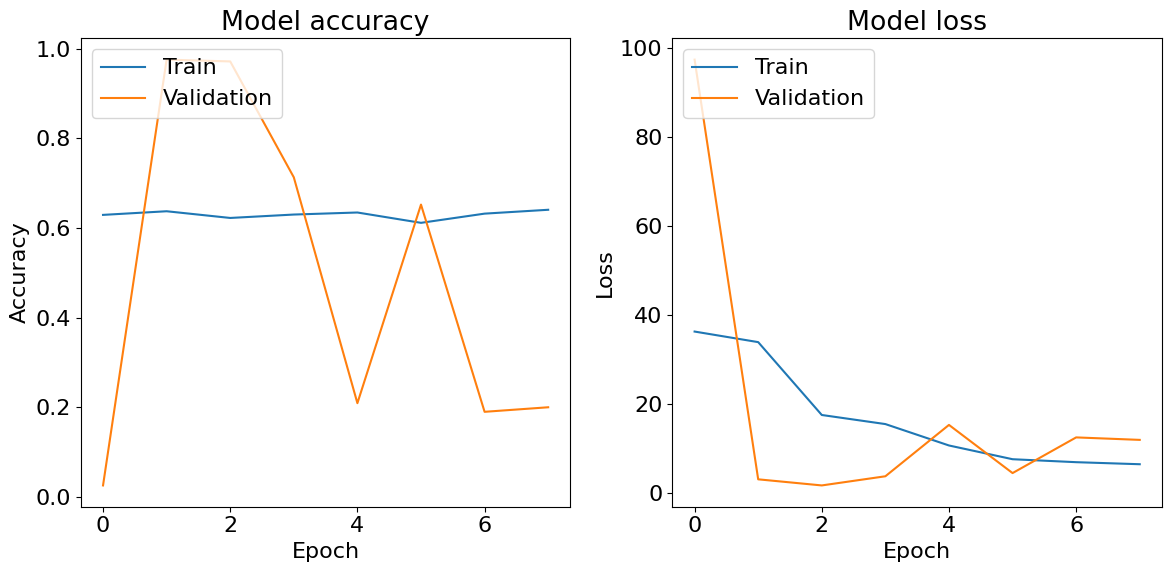

In [101]:
plot_training_curves(hs_elb)

8/8 [==============================] - 4s 423ms/step - loss: 5.9873 - auc: 0.5313 - accuracy: 0.5097 - cohen_kappa: 0.0132 - f1_score: 0.3049
Train Loss     : 6.51864
Validation Loss: 11.99357
Test Loss      : 5.98725
---
Train AUC     : 0.54398
Validation AUC: 0.48996
Test AUC      : 0.53130
---
Train Accuracy     : 0.64056
Validation Accuracy: 0.19980
Test Accuracy      : 0.50968
---
Train Kappa     : 0.06731
Validation Kappa: 0.00021
Test Kappa      : 0.01322


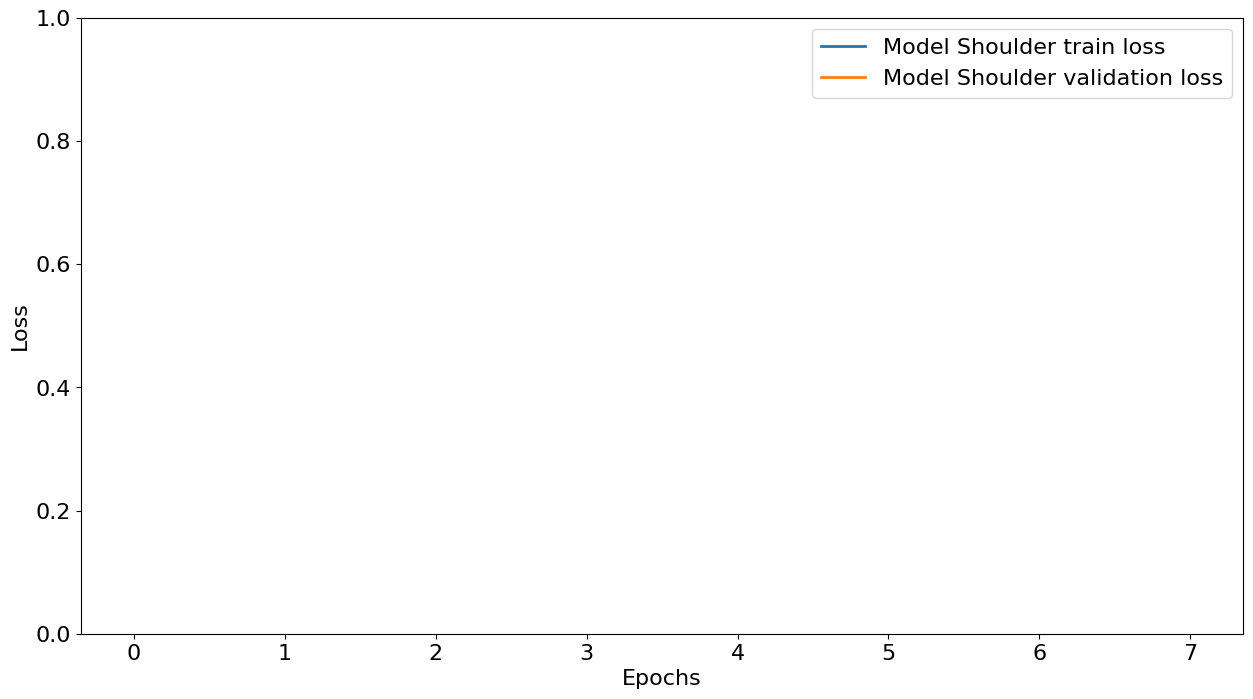

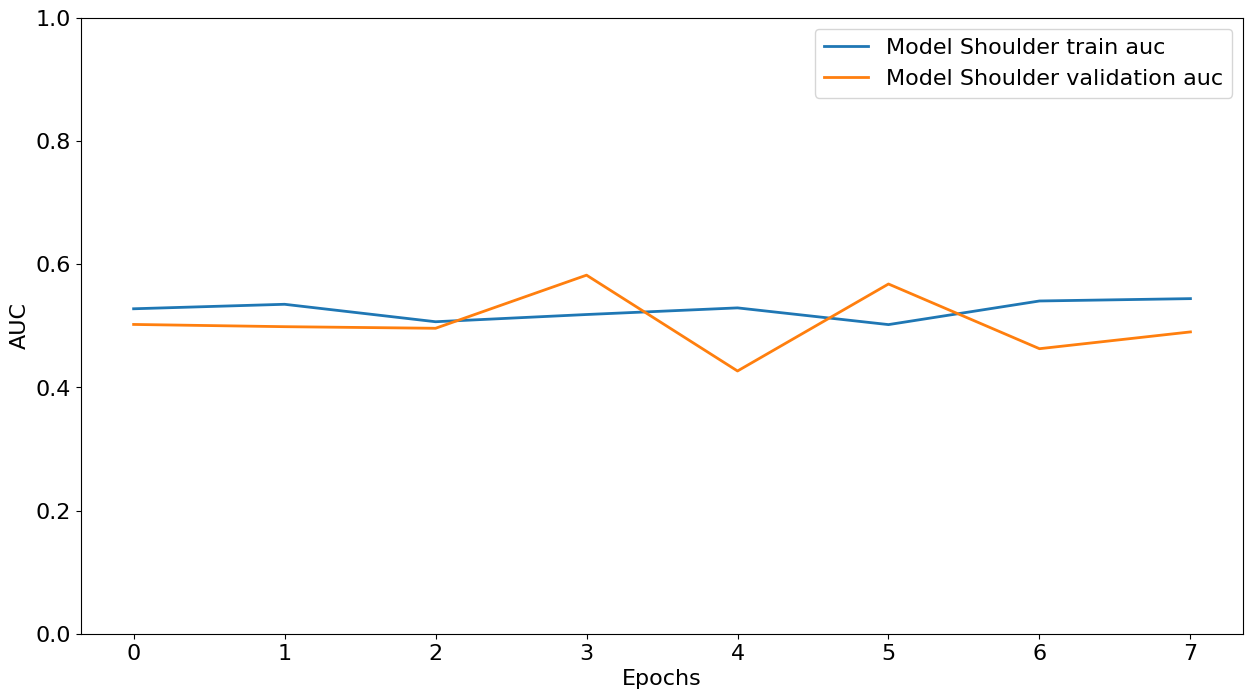

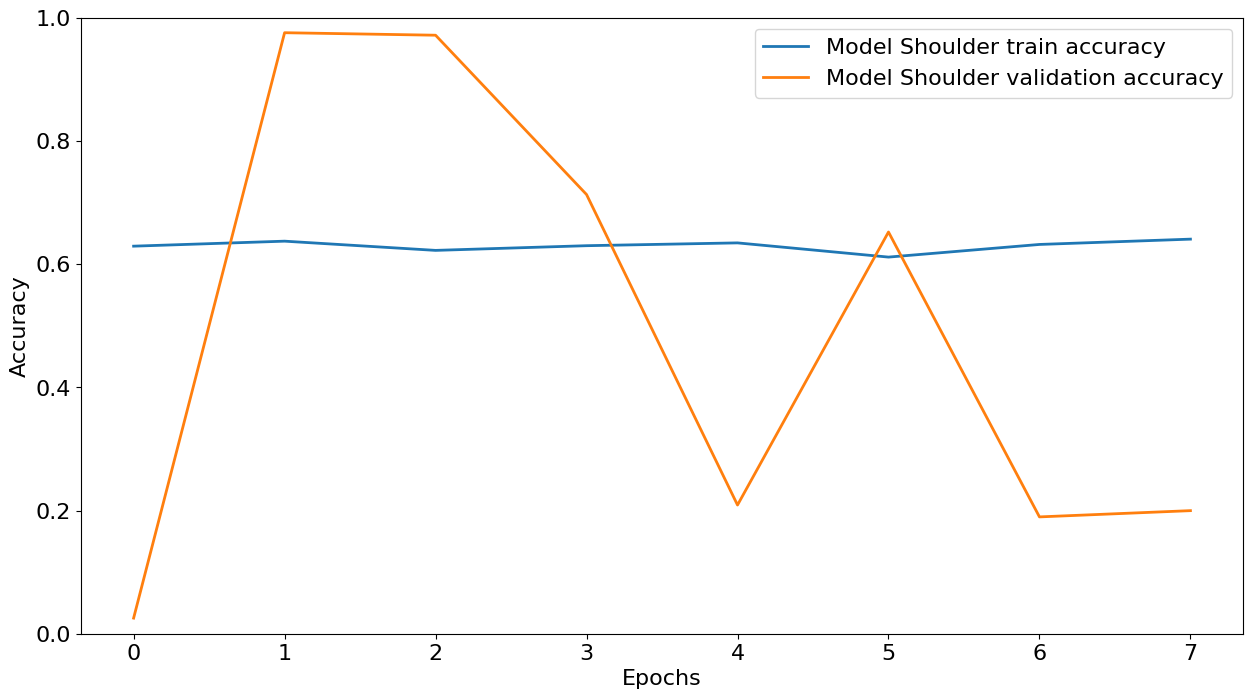

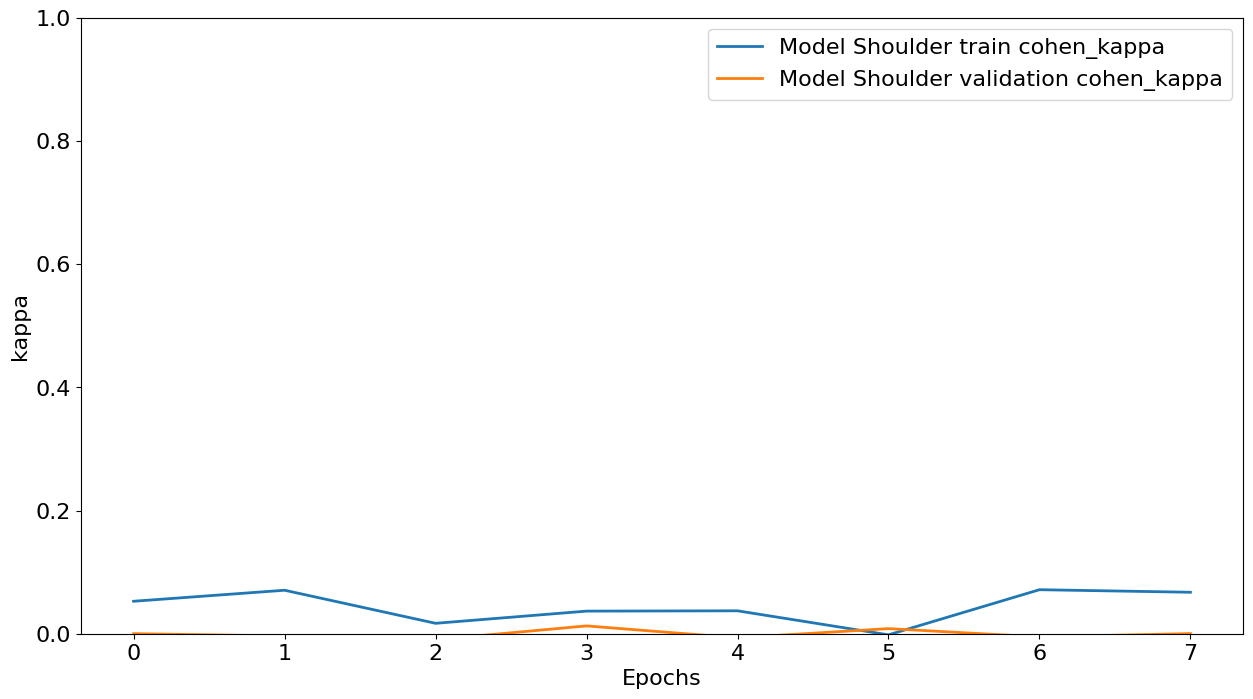

In [102]:
model_eval = model.evaluate(testset_elbow)
# clean_up(model=model)
print_results(model_name='Model Shoulder',epochs= EPOCHS, hs = hs_elb, model_eval = model_eval)

### XR_HUMERUS

In [103]:
trainset_hum = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="training",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

validset_hum = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="validation",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

testset_hum = generator.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=False,
    validate_filenames=True,
    workers=4,  # Adjust based on your CPU
    use_multiprocessing=True
)

Found 1018 validated image filenames belonging to 2 classes.
Found 254 validated image filenames belonging to 2 classes.
Found 288 validated image filenames belonging to 2 classes.


In [104]:
hs_hum = model.fit(
    trainset_hum,
    validation_data = validset_hum, 
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

print('Training.')
print('------------------')
model.summary()
filename = 'models/model_hum.keras'
model.save(filename)
print('>Saved %s' % filename)

Epoch 1/100
16/16 [==============================] - 17s 1s/step - loss: 11.3498 - auc: 0.4942 - accuracy: 0.5992 - cohen_kappa: -0.0100 - f1_score: 0.2243 - val_loss: 18.4743 - val_auc: 0.6468 - val_accuracy: 0.2362 - val_cohen_kappa: 0.0047 - val_f1_score: 0.3742 - lr: 1.0000e-06
Epoch 2/100
16/16 [==============================] - 15s 900ms/step - loss: 10.0163 - auc: 0.4975 - accuracy: 0.6002 - cohen_kappa: -0.0035 - f1_score: 0.2335 - val_loss: 17.1480 - val_auc: 0.6508 - val_accuracy: 0.2559 - val_cohen_kappa: 0.0052 - val_f1_score: 0.4000 - lr: 1.0000e-06
Epoch 3/100
16/16 [==============================] - 15s 899ms/step - loss: 9.6908 - auc: 0.4968 - accuracy: 0.5874 - cohen_kappa: -0.0157 - f1_score: 0.2446 - val_loss: 16.1202 - val_auc: 0.4474 - val_accuracy: 0.1969 - val_cohen_kappa: 0.0037 - val_f1_score: 0.3200 - lr: 1.0000e-06
Epoch 4/100
16/16 [==============================] - 15s 896ms/step - loss: 10.3276 - auc: 0.4752 - accuracy: 0.5678 - cohen_kappa: -0.0354 - f1_s

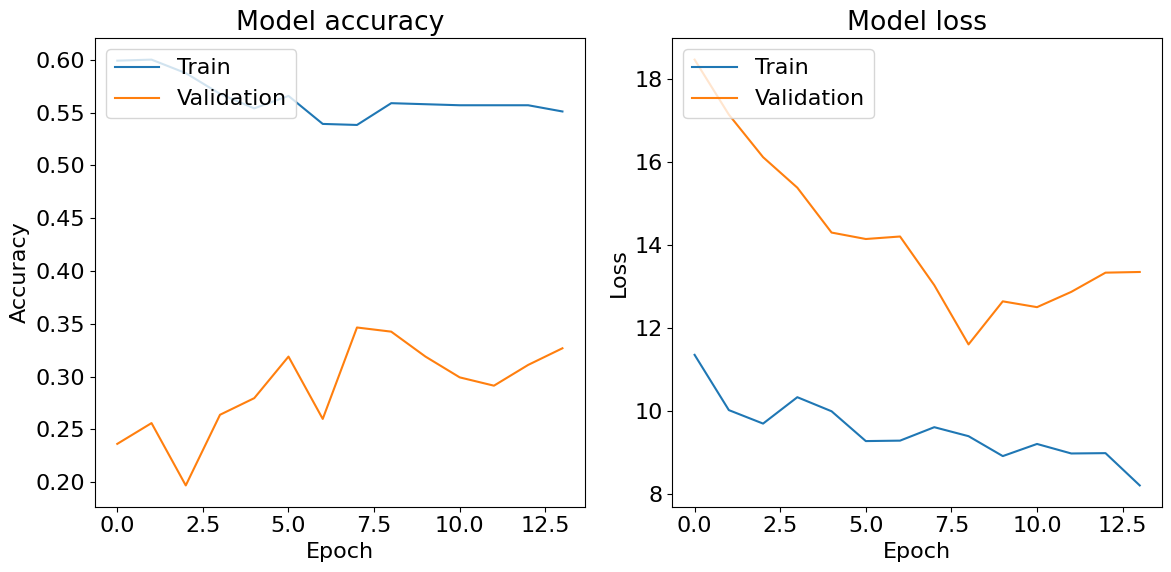

In [105]:
plot_training_curves(hs_hum)

5/5 [==============================] - 2s 424ms/step - loss: 9.4057 - auc: 0.4422 - accuracy: 0.4618 - cohen_kappa: -0.0918 - f1_score: 0.2654
Train Loss     : 8.19838
Validation Loss: 13.34960
Test Loss      : 9.40567
---
Train AUC     : 0.50305
Validation AUC: 0.50992
Test AUC      : 0.44221
---
Train Accuracy     : 0.55108
Validation Accuracy: 0.32677
Test Accuracy      : 0.46181
---
Train Kappa     : -0.01529
Validation Kappa: 0.00740
Test Kappa      : -0.09176


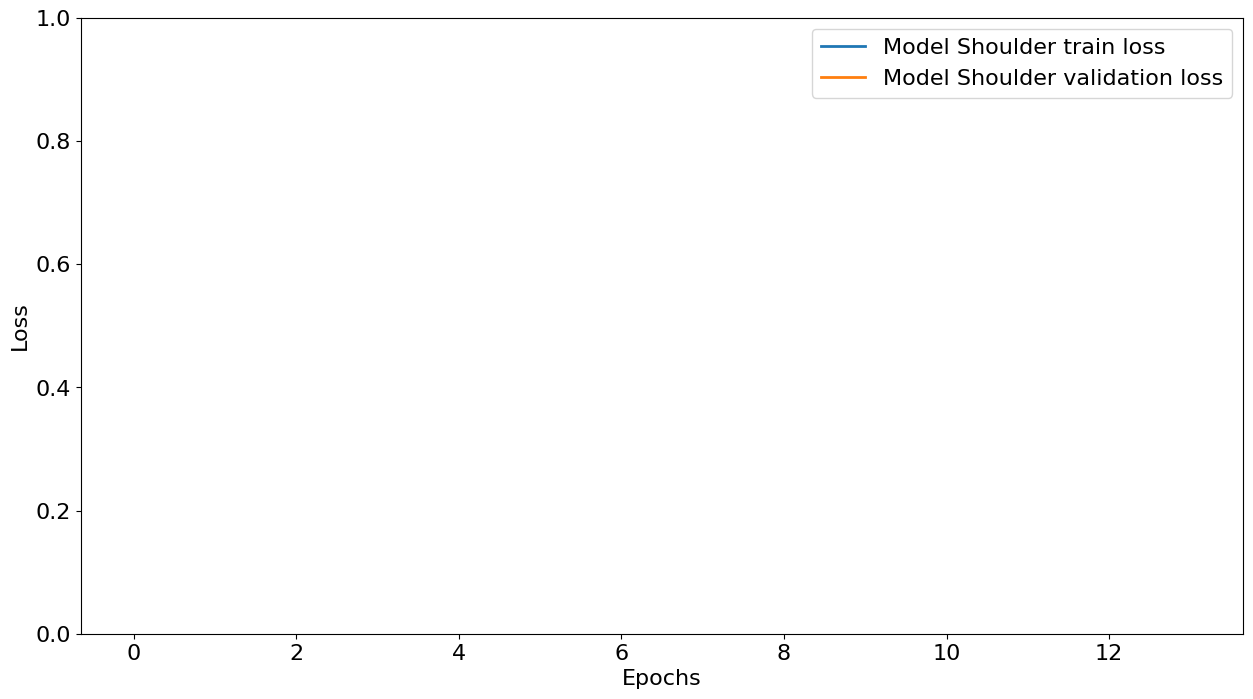

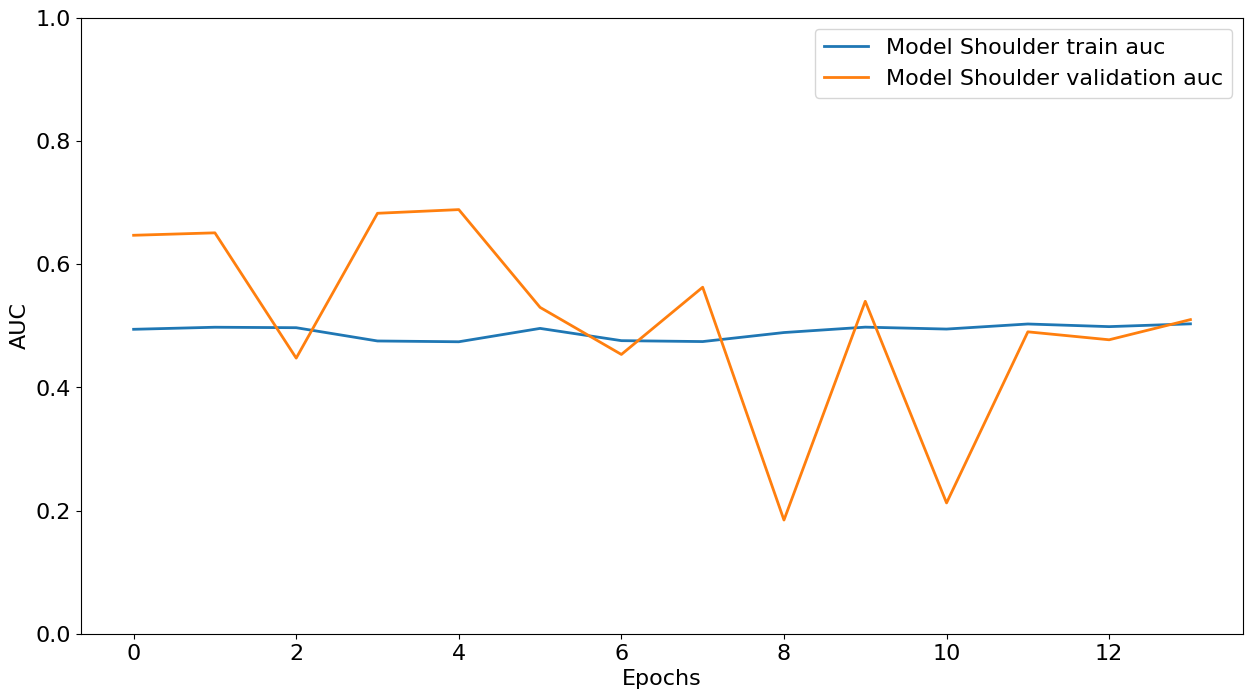

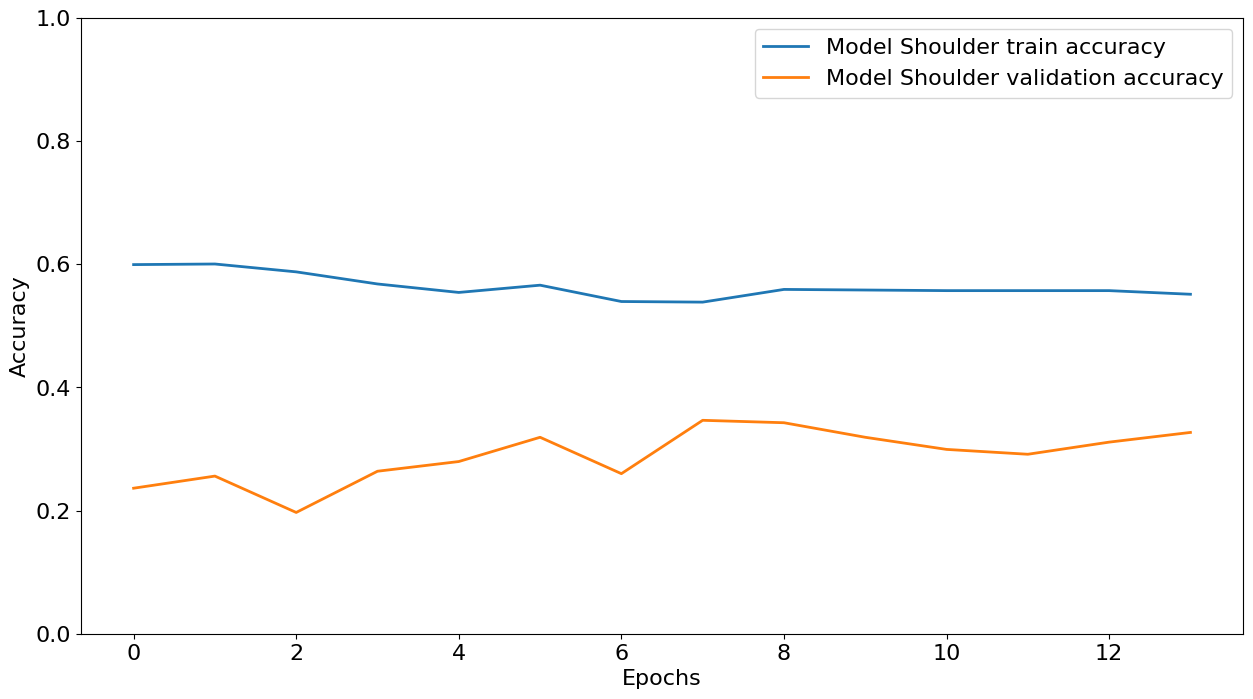

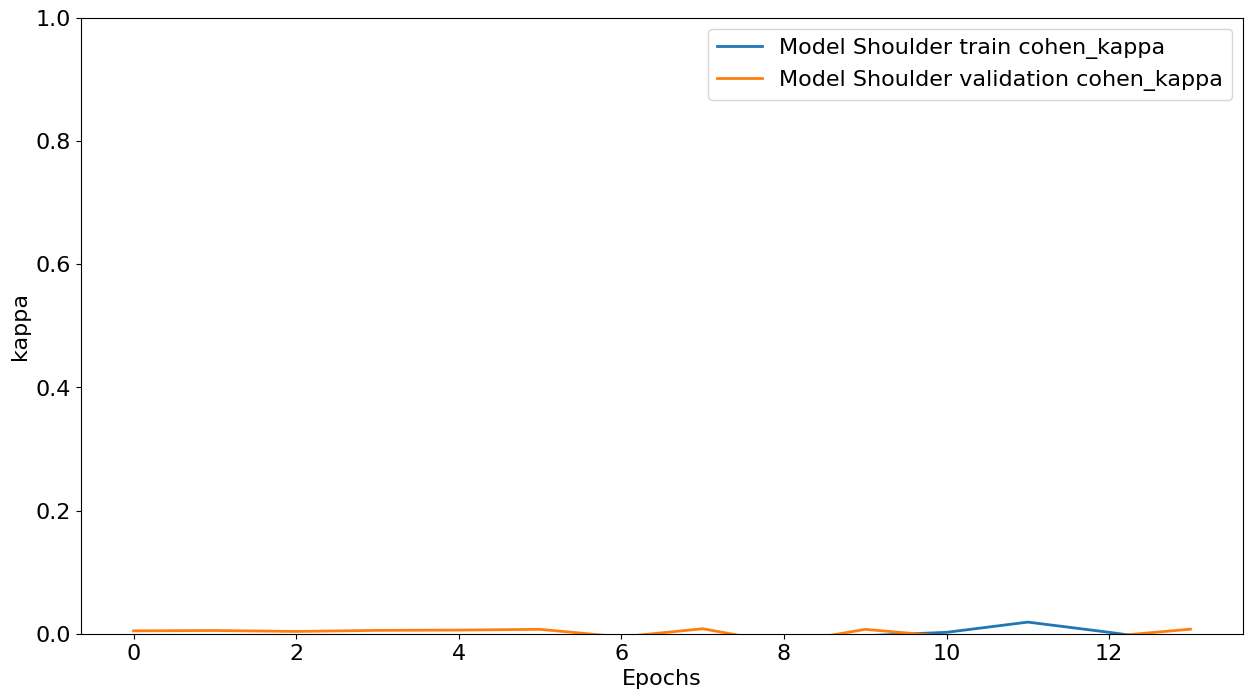

In [106]:
model_eval = model.evaluate(testset_hum)
# clean_up(model=model)
print_results(model_name='Model Shoulder',epochs= EPOCHS, hs = hs_hum, model_eval = model_eval)

### XR_HAND

In [107]:
trainset_hand = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="training",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

validset_hand = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="validation",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

testset_hand = generator.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=False,
    validate_filenames=True,
    workers=4,  # Adjust based on your CPU
    use_multiprocessing=True
)

Found 4435 validated image filenames belonging to 2 classes.
Found 1108 validated image filenames belonging to 2 classes.
Found 460 validated image filenames belonging to 2 classes.


In [108]:
hs_hand = model.fit(
    trainset_hand,
    validation_data = validset_hand, 
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

print('Training.')
print('------------------')
model.summary()
filename = 'models/model_hum.keras'
model.save(filename)
print('>Saved %s' % filename)

Epoch 1/100
70/70 [==============================] - 65s 920ms/step - loss: 8.6986 - auc: 0.5089 - accuracy: 0.4710 - cohen_kappa: 0.0103 - f1_score: 0.1728 - val_loss: 7.8950 - val_auc: 0.5576 - val_accuracy: 0.3646 - val_cohen_kappa: 0.0065 - val_f1_score: 0.5104 - lr: 1.0000e-09
Epoch 2/100
70/70 [==============================] - 63s 892ms/step - loss: 8.4102 - auc: 0.5055 - accuracy: 0.4764 - cohen_kappa: 0.0027 - f1_score: 0.1659 - val_loss: 6.2357 - val_auc: 0.5545 - val_accuracy: 0.4955 - val_cohen_kappa: 0.0040 - val_f1_score: 0.6508 - lr: 1.0000e-09
Epoch 3/100
70/70 [==============================] - 63s 890ms/step - loss: 8.6298 - auc: 0.5111 - accuracy: 0.4604 - cohen_kappa: 0.0023 - f1_score: 0.1665 - val_loss: 6.3143 - val_auc: 0.6202 - val_accuracy: 0.5253 - val_cohen_kappa: 0.0396 - val_f1_score: 0.6745 - lr: 1.0000e-09
Epoch 4/100
70/70 [==============================] - 63s 897ms/step - loss: 8.4805 - auc: 0.5051 - accuracy: 0.4726 - cohen_kappa: 0.0075 - f1_score: 0

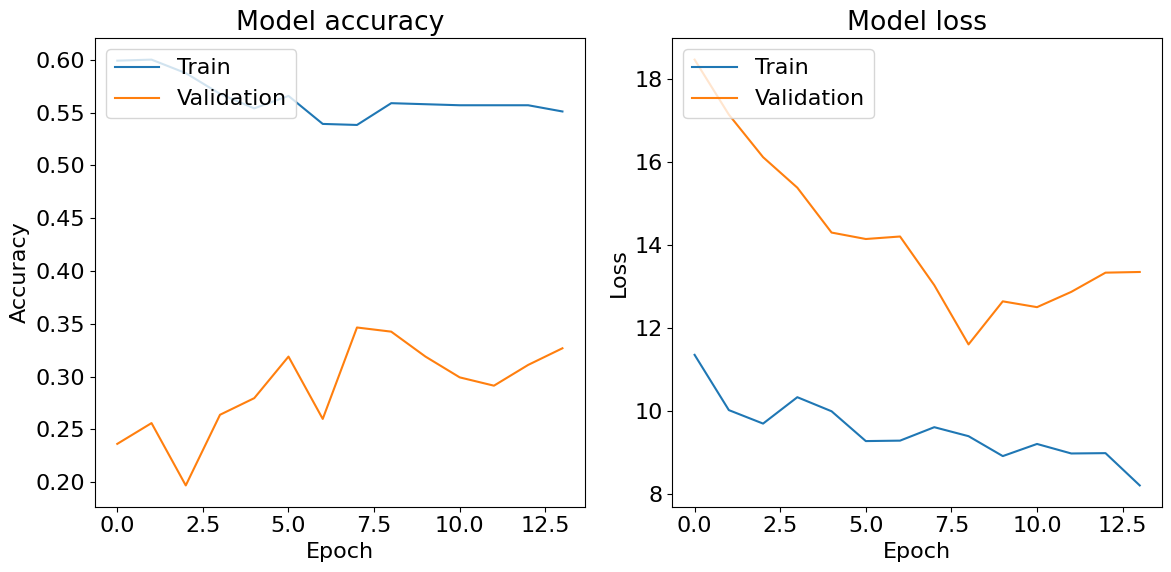

In [109]:
plot_training_curves(hs_hum)

8/8 [==============================] - 4s 425ms/step - loss: 4.8792 - auc: 0.5501 - accuracy: 0.5457 - cohen_kappa: 0.0955 - f1_score: 0.5082
Train Loss     : 8.31510
Validation Loss: 6.46505
Test Loss      : 4.87920
---
Train AUC     : 0.49679
Validation AUC: 0.48720
Test AUC      : 0.55006
---
Train Accuracy     : 0.47621
Validation Accuracy: 0.52978
Test Accuracy      : 0.54565
---
Train Kappa     : -0.00429
Validation Kappa: 0.00431
Test Kappa      : 0.09551


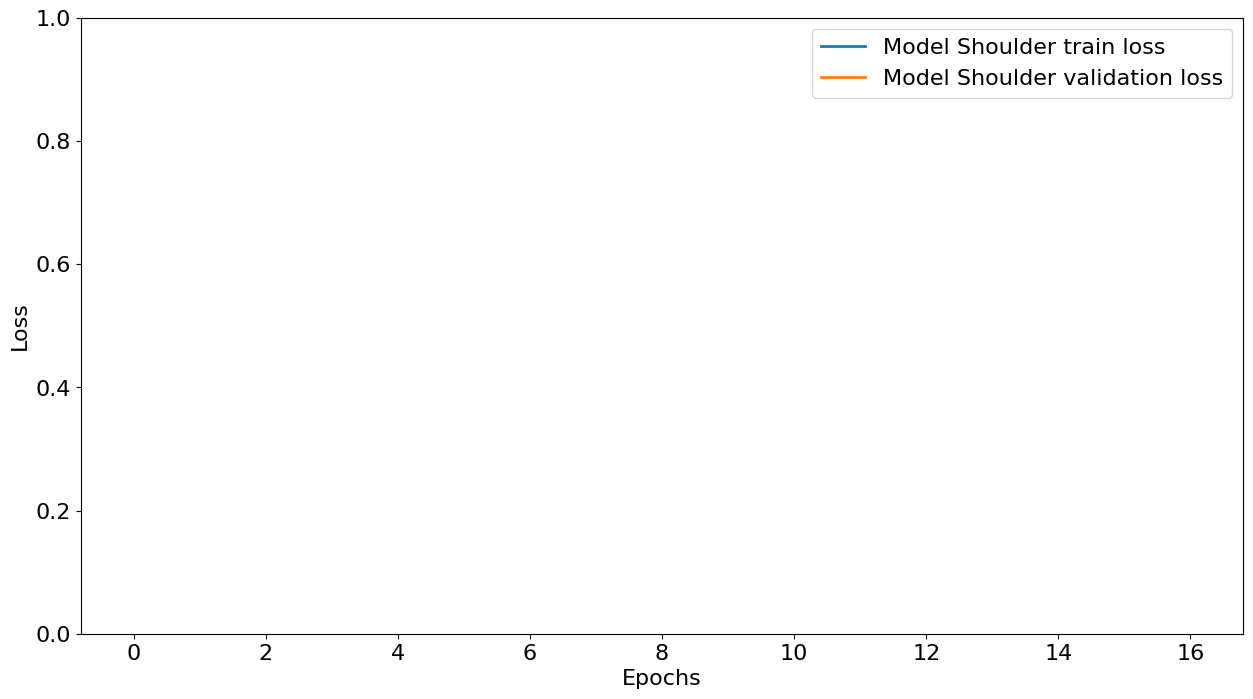

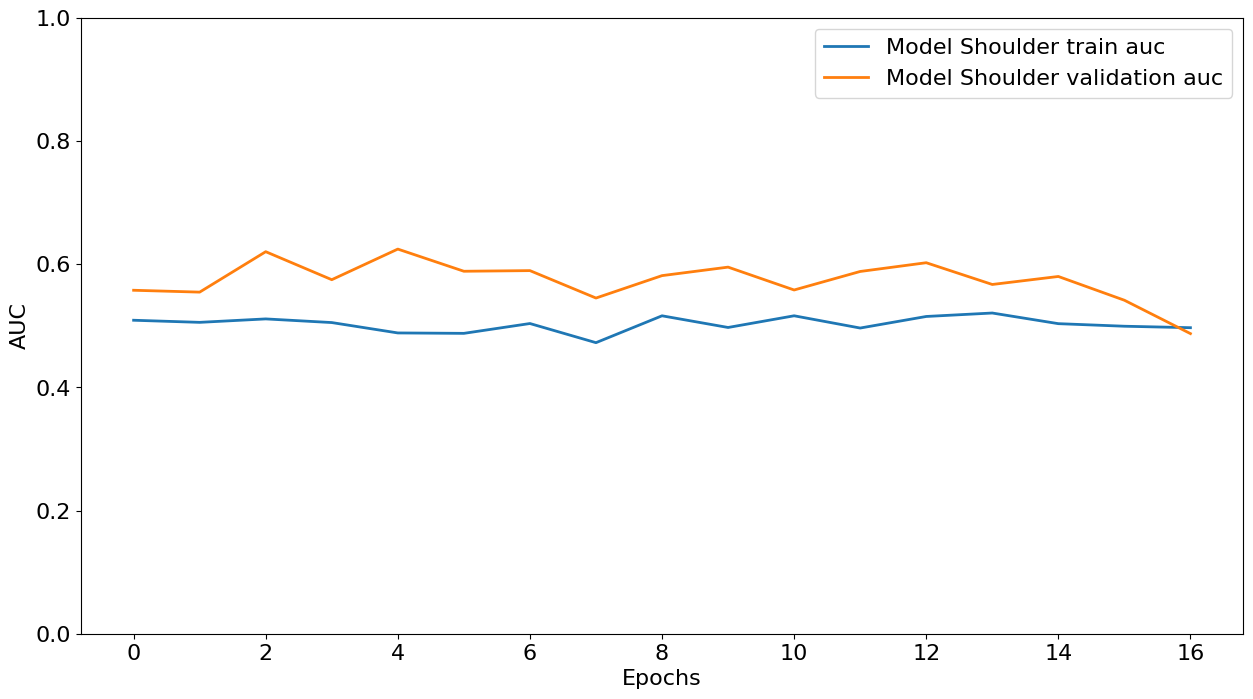

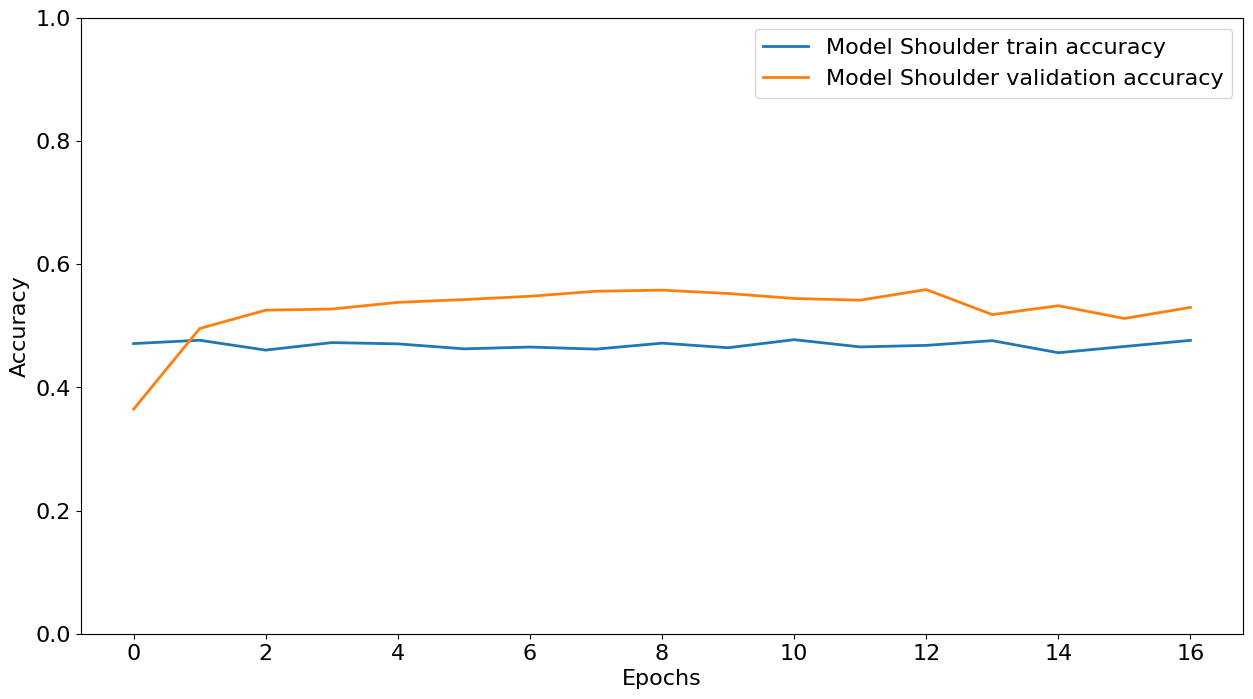

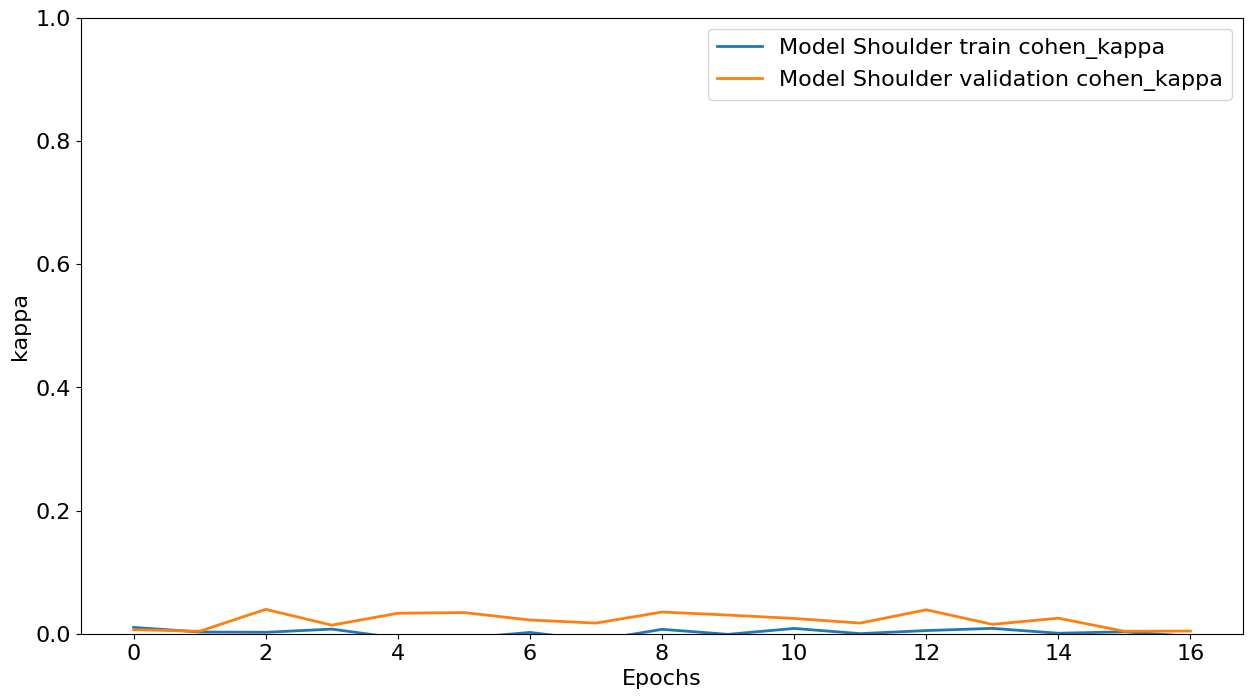

In [110]:
model_eval = model.evaluate(testset_hand)
# clean_up(model=model)
print_results(model_name='Model Shoulder',epochs= EPOCHS, hs = hs_hand, model_eval = model_eval)

### XR_WRIST

In [112]:
trainset_wrist = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="training",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

validset_wrist = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="validation",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

testset_wrist = generator.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=False,
    validate_filenames=True,
    workers=4,  # Adjust based on your CPU
    use_multiprocessing=True
)

Found 7802 validated image filenames belonging to 2 classes.
Found 1950 validated image filenames belonging to 2 classes.
Found 659 validated image filenames belonging to 2 classes.


In [113]:
hs_wrist = model.fit(
    trainset_wrist,
    validation_data = validset_wrist, 
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

print('Training.')
print('------------------')
model.summary()
filename = 'models/model_wrist.keras'
model.save(filename)
print('>Saved %s' % filename)

Epoch 1/100
122/122 [==============================] - 109s 893ms/step - loss: 6.8943 - auc: 0.5411 - accuracy: 0.5533 - cohen_kappa: 0.0595 - f1_score: 0.3809 - val_loss: 7.6466 - val_auc: 0.5508 - val_accuracy: 0.4328 - val_cohen_kappa: 0.0159 - val_f1_score: 0.5782 - lr: 1.0000e-12
Epoch 2/100
122/122 [==============================] - 108s 885ms/step - loss: 6.9142 - auc: 0.5533 - accuracy: 0.5569 - cohen_kappa: 0.0635 - f1_score: 0.3823 - val_loss: 7.9767 - val_auc: 0.5389 - val_accuracy: 0.4103 - val_cohen_kappa: 0.0132 - val_f1_score: 0.5532 - lr: 1.0000e-12
Epoch 3/100
122/122 [==============================] - 108s 886ms/step - loss: 6.9708 - auc: 0.5411 - accuracy: 0.5592 - cohen_kappa: 0.0620 - f1_score: 0.3794 - val_loss: 8.1641 - val_auc: 0.5248 - val_accuracy: 0.3836 - val_cohen_kappa: 0.0056 - val_f1_score: 0.5238 - lr: 1.0000e-12
Epoch 4/100
122/122 [==============================] - 109s 894ms/step - loss: 6.6704 - auc: 0.5643 - accuracy: 0.5701 - cohen_kappa: 0.0911 -

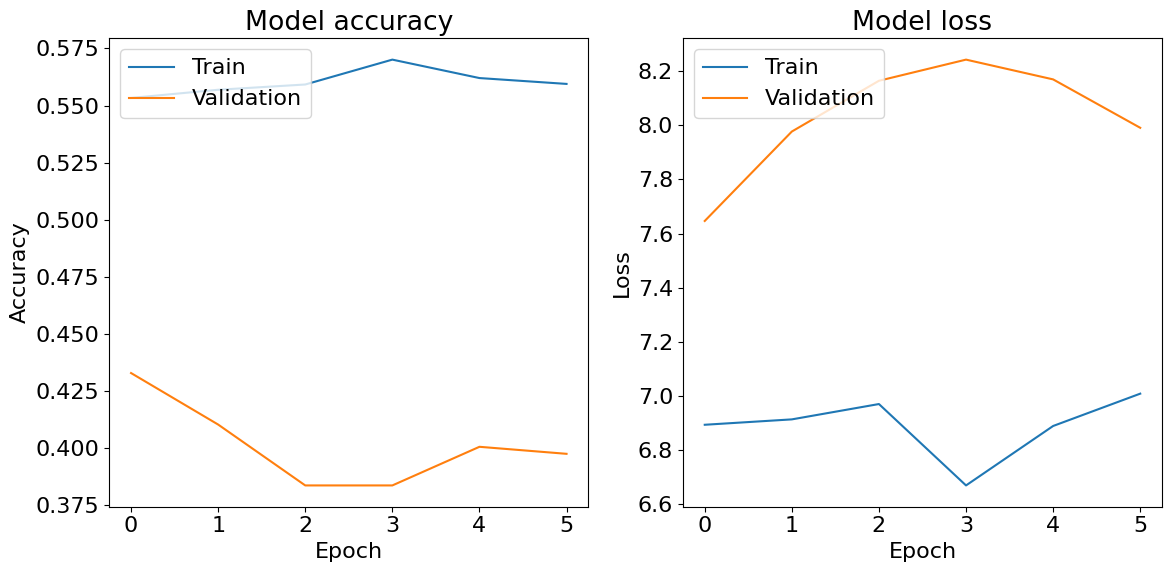

In [114]:
plot_training_curves(hs_wrist)

11/11 [==============================] - 5s 439ms/step - loss: 4.8749 - auc: 0.5978 - accuracy: 0.6055 - cohen_kappa: 0.1844 - f1_score: 0.5019
Train Loss     : 7.00913
Validation Loss: 7.99052
Test Loss      : 4.87488
---
Train AUC     : 0.54662
Validation AUC: 0.56111
Test AUC      : 0.59783
---
Train Accuracy     : 0.55947
Validation Accuracy: 0.39744
Test Accuracy      : 0.60546
---
Train Kappa     : 0.07091
Validation Kappa: 0.01449
Test Kappa      : 0.18436


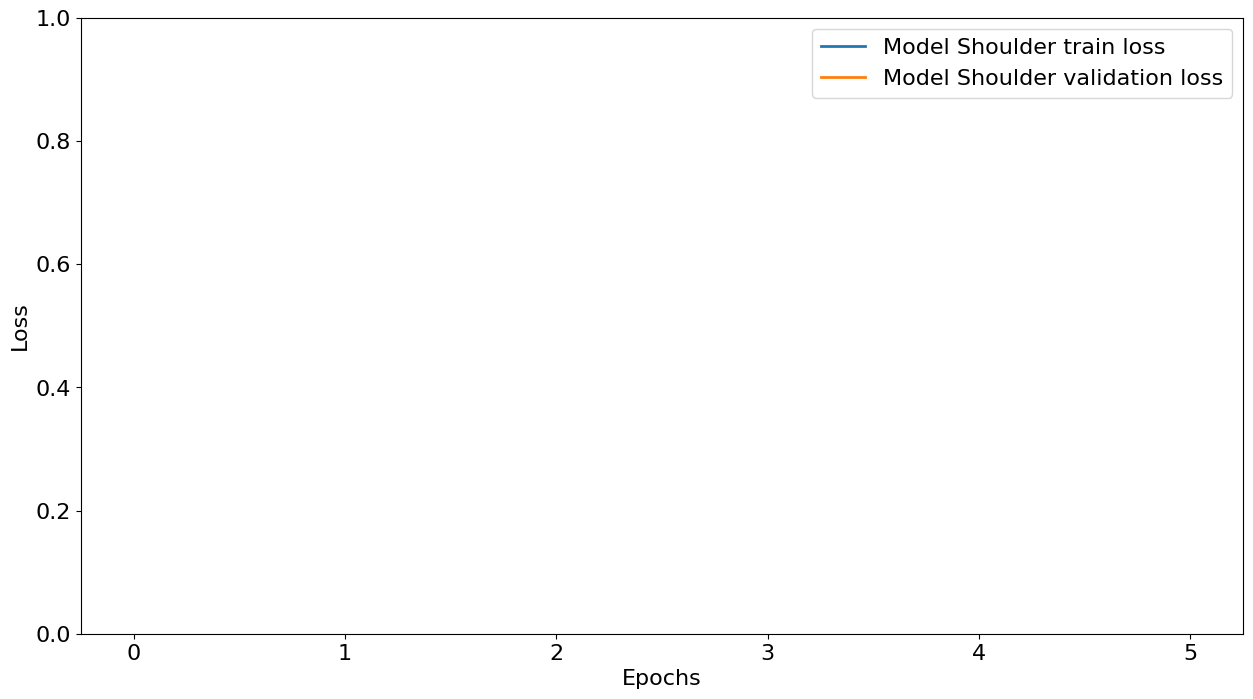

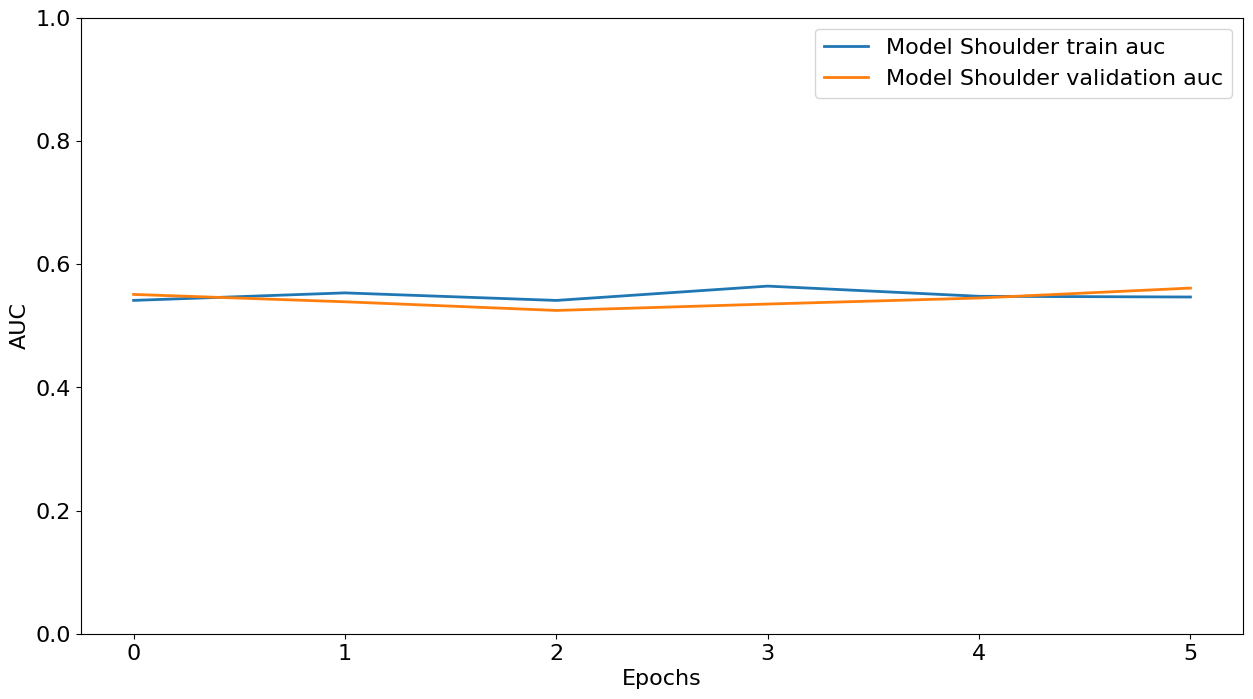

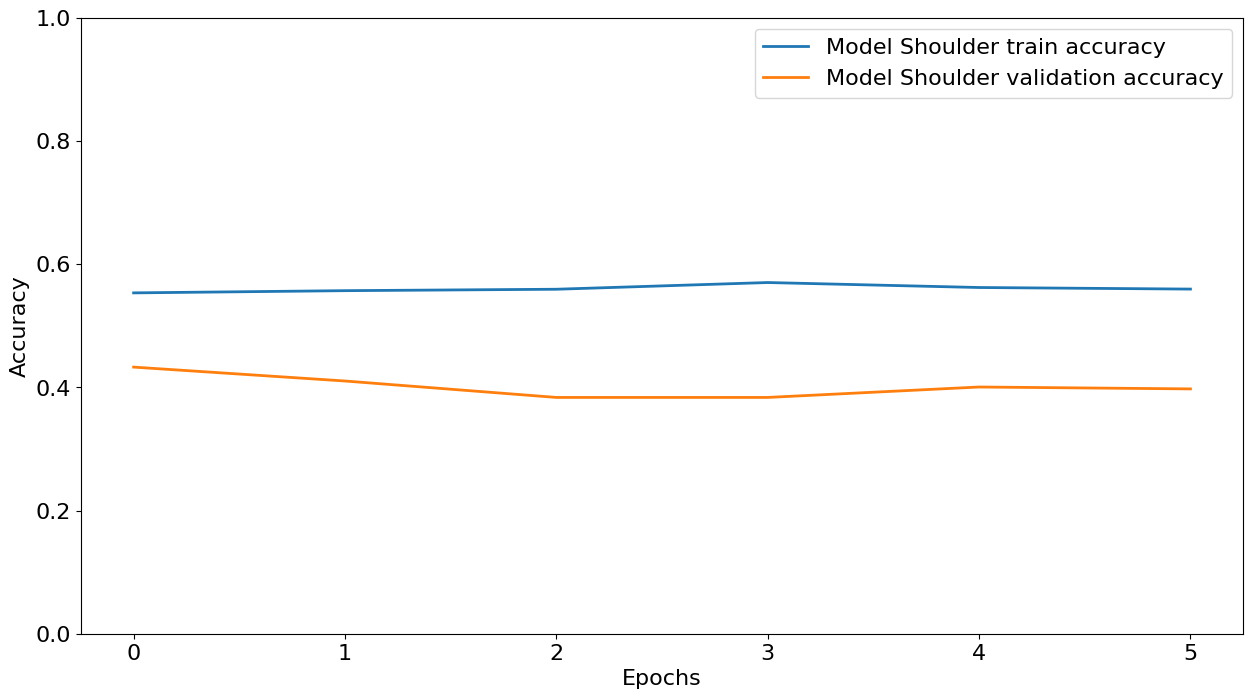

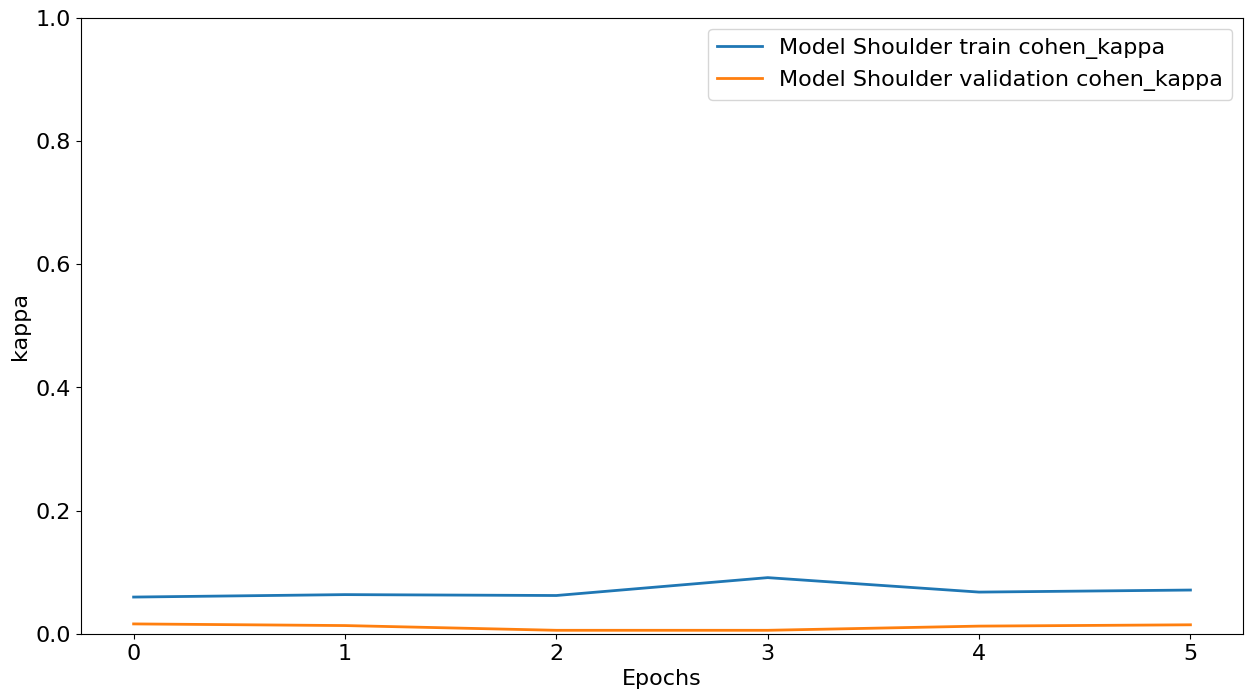

In [115]:
model_eval = model.evaluate(testset_wrist)
# clean_up(model=model)
print_results(model_name='Model Shoulder',epochs= EPOCHS, hs = hs_wrist, model_eval = model_eval)

### XR_FOREARM

In [116]:
trainset_forearm = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="training",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

validset_forearm = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="validation",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

testset_forearm = generator.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=False,
    validate_filenames=True,
    workers=4,  # Adjust based on your CPU
    use_multiprocessing=True
)

Found 1460 validated image filenames belonging to 2 classes.
Found 365 validated image filenames belonging to 2 classes.
Found 301 validated image filenames belonging to 2 classes.


In [117]:
hs_forearm = model.fit(
    trainset_forearm,
    validation_data = validset_forearm, 
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

print('Training.')
print('------------------')
model.summary()
filename = 'models/model_forearm.keras'
model.save(filename)
print('>Saved %s' % filename)

Epoch 1/100
23/23 [==============================] - 23s 978ms/step - loss: 6.8434 - auc: 0.5377 - accuracy: 0.6096 - cohen_kappa: 0.0383 - f1_score: 0.2839 - val_loss: 12.3973 - val_auc: 0.3926 - val_accuracy: 0.2822 - val_cohen_kappa: -0.0033 - val_f1_score: 0.4378 - lr: 1.0000e-14
Epoch 2/100
23/23 [==============================] - 21s 902ms/step - loss: 7.6896 - auc: 0.5102 - accuracy: 0.5932 - cohen_kappa: 0.0038 - f1_score: 0.2594 - val_loss: 12.2882 - val_auc: 0.7273 - val_accuracy: 0.3041 - val_cohen_kappa: 0.0047 - val_f1_score: 0.4619 - lr: 1.0000e-14
Epoch 3/100
23/23 [==============================] - 21s 895ms/step - loss: 7.2873 - auc: 0.5223 - accuracy: 0.6055 - cohen_kappa: 0.0378 - f1_score: 0.2854 - val_loss: 12.0683 - val_auc: 0.5634 - val_accuracy: 0.3068 - val_cohen_kappa: 0.0047 - val_f1_score: 0.4651 - lr: 1.0000e-14
Epoch 4/100
23/23 [==============================] - 21s 900ms/step - loss: 6.7607 - auc: 0.5198 - accuracy: 0.6055 - cohen_kappa: 0.0243 - f1_scor

5/5 [==============================] - 2s 445ms/step - loss: 7.1407 - auc: 0.6009 - accuracy: 0.5748 - cohen_kappa: 0.1509 - f1_score: 0.4336
Train Loss     : 7.07416
Validation Loss: 12.65479
Test Loss      : 7.14067
---
Train AUC     : 0.53390
Validation AUC: 0.39050
Test AUC      : 0.60095
---
Train Accuracy     : 0.61370
Validation Accuracy: 0.26027
Test Accuracy      : 0.57475
---
Train Kappa     : 0.04462
Validation Kappa: -0.00356
Test Kappa      : 0.15092


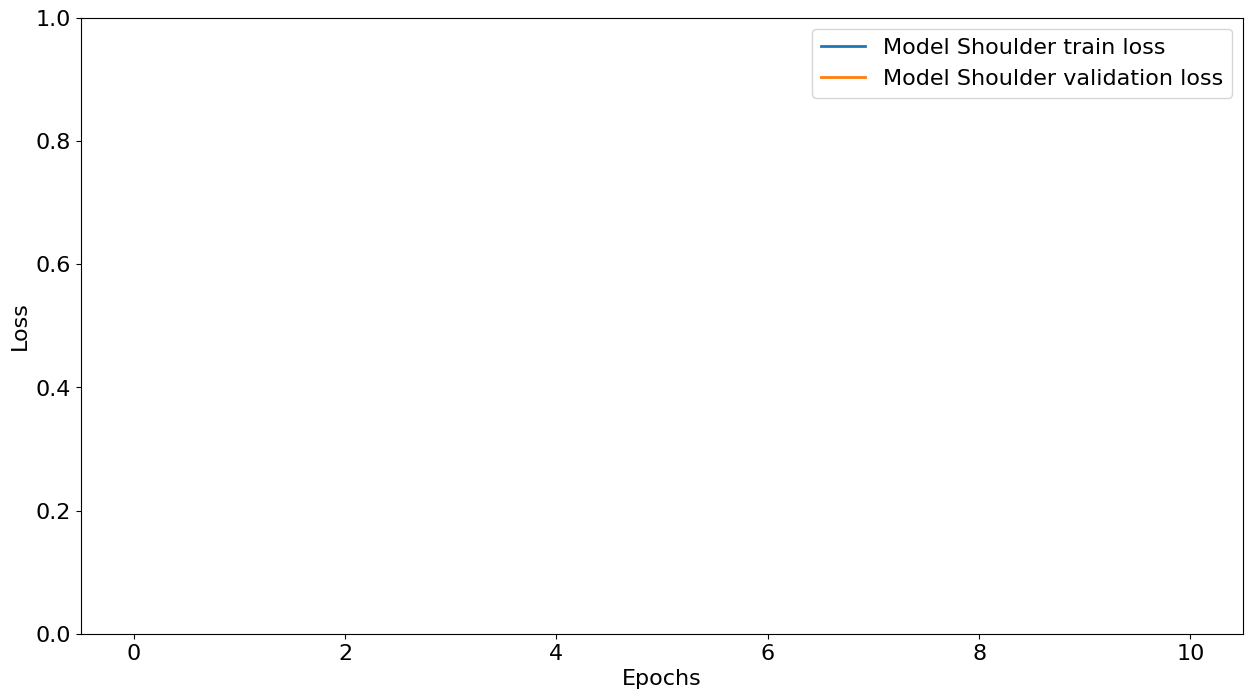

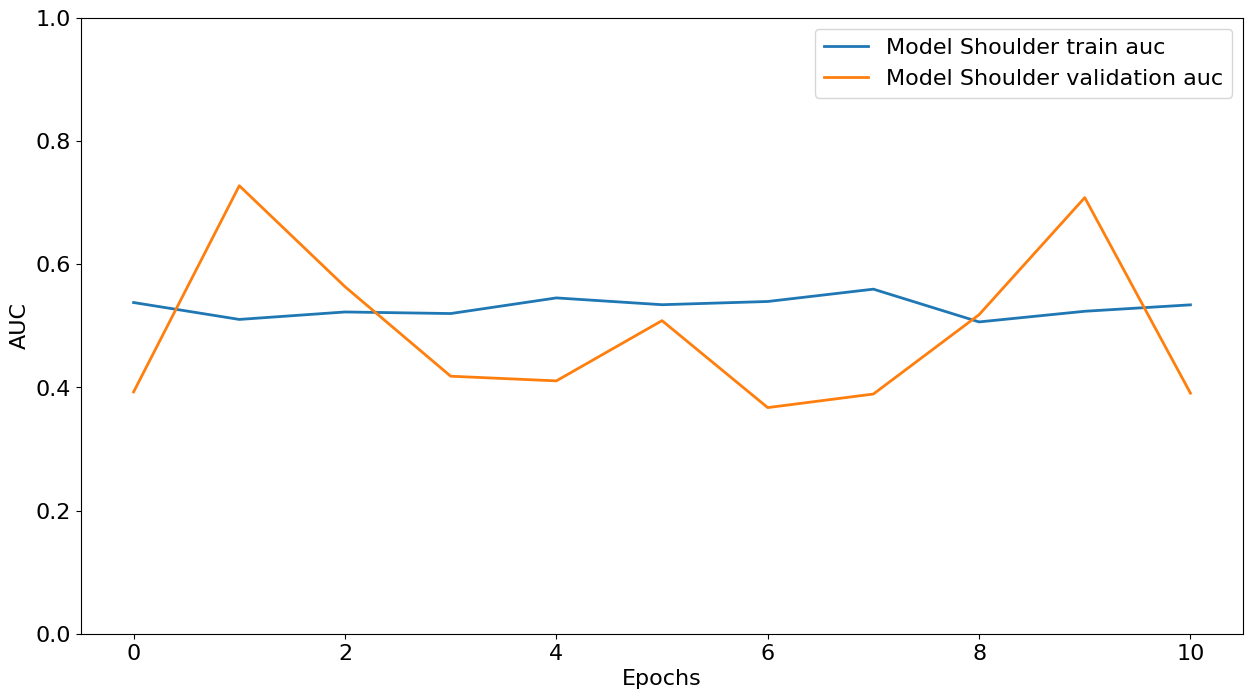

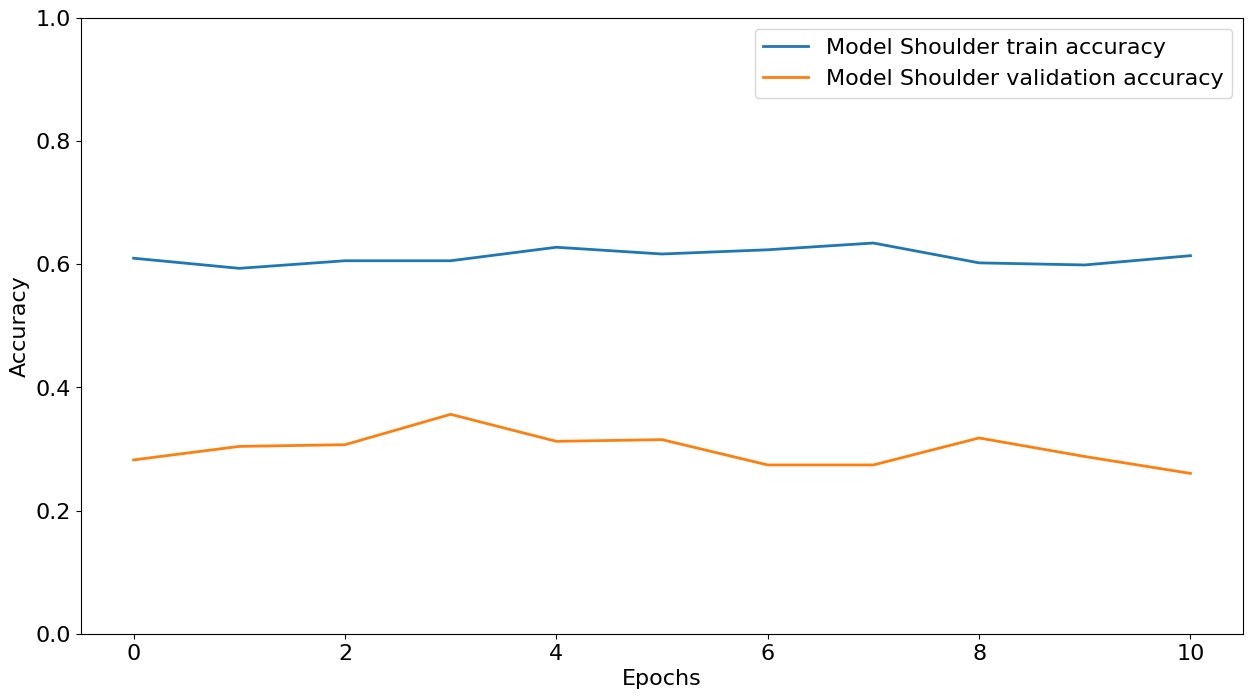

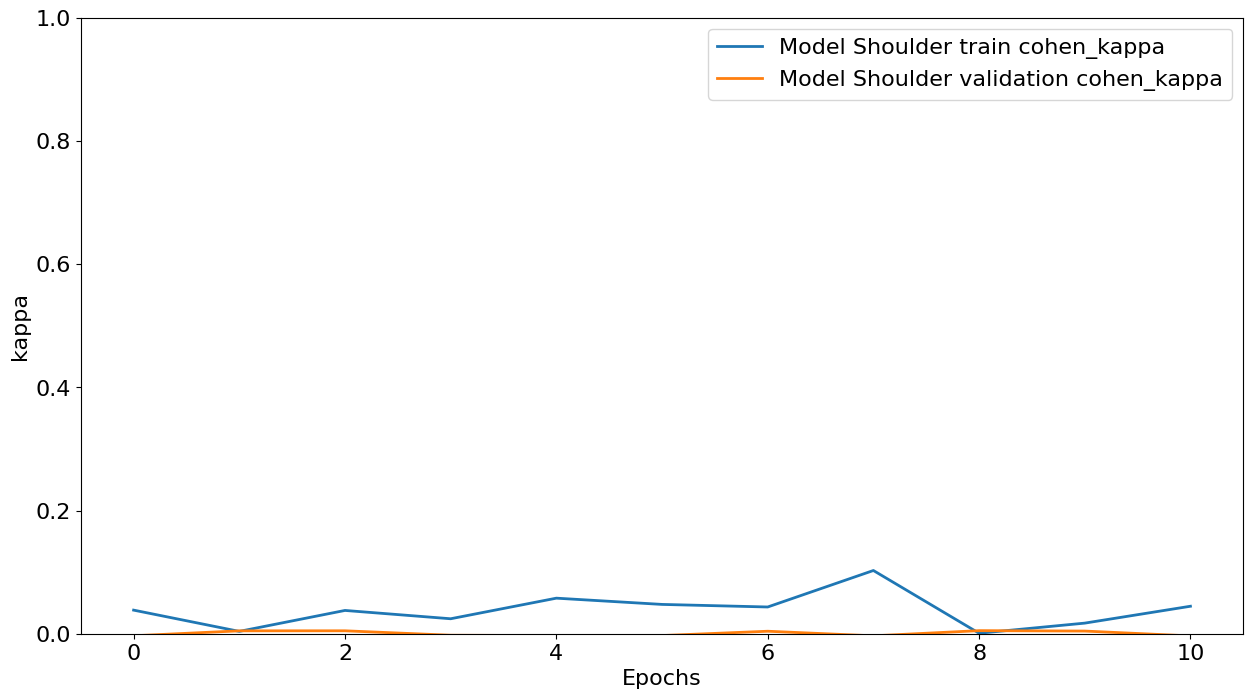

In [118]:
model_eval = model.evaluate(testset_forearm)
# clean_up(model=model)
print_results(model_name='Model Shoulder',epochs= EPOCHS, hs = hs_forearm, model_eval = model_eval)

### XR_FINGER

In [119]:
trainset_finger = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="training",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

validset_finger = generator.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    subset="validation",
    validate_filenames=True,
    workers=8,  # Adjust based on your CPU
    use_multiprocessing=True
)

testset_finger = generator.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=batch_size,
    seed=SEED,
    shuffle=False,
    validate_filenames=True,
    workers=4,  # Adjust based on your CPU
    use_multiprocessing=True
)

Found 4085 validated image filenames belonging to 2 classes.
Found 1021 validated image filenames belonging to 2 classes.
Found 461 validated image filenames belonging to 2 classes.


In [120]:
hs_finger = model.fit(
    trainset_finger,
    validation_data = validset_finger, 
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

print('Training.')
print('------------------')
model.summary()
filename = 'models/model_finger.keras'
model.save(filename)
print('>Saved %s' % filename)

Epoch 1/100
64/64 [==============================] - 63s 964ms/step - loss: 6.3999 - auc: 0.5372 - accuracy: 0.6007 - cohen_kappa: 0.0580 - f1_score: 0.3274 - val_loss: 11.9399 - val_auc: 0.5695 - val_accuracy: 0.2008 - val_cohen_kappa: 0.0093 - val_f1_score: 0.2978 - lr: 1.0000e-17
Epoch 2/100
64/64 [==============================] - 61s 945ms/step - loss: 6.4764 - auc: 0.5483 - accuracy: 0.6049 - cohen_kappa: 0.0631 - f1_score: 0.3297 - val_loss: 10.9069 - val_auc: 0.5195 - val_accuracy: 0.2331 - val_cohen_kappa: 6.6251e-04 - val_f1_score: 0.3502 - lr: 1.0000e-17
Epoch 3/100
64/64 [==============================] - 57s 890ms/step - loss: 6.2510 - auc: 0.5433 - accuracy: 0.6007 - cohen_kappa: 0.0648 - f1_score: 0.3340 - val_loss: 11.3516 - val_auc: 0.5669 - val_accuracy: 0.2214 - val_cohen_kappa: 0.0066 - val_f1_score: 0.3302 - lr: 1.0000e-17
Epoch 4/100
64/64 [==============================] - 57s 884ms/step - loss: 6.2371 - auc: 0.5553 - accuracy: 0.6149 - cohen_kappa: 0.0849 - f1_s

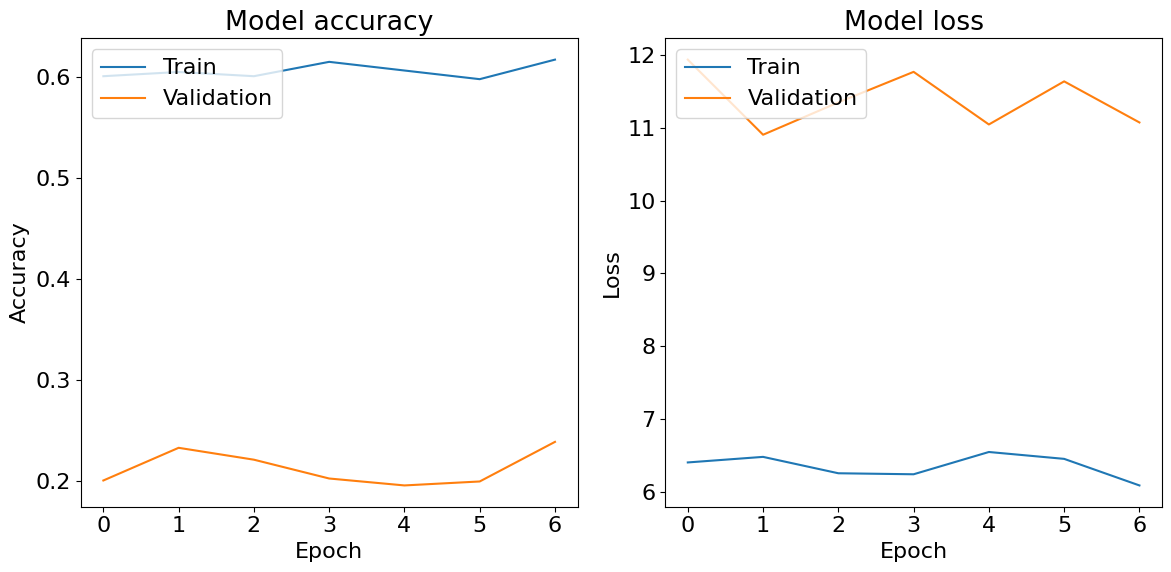

In [123]:
plot_training_curves(hs_finger)

8/8 [==============================] - 3s 402ms/step - loss: 7.2635 - auc: 0.5402 - accuracy: 0.4989 - cohen_kappa: 0.0409 - f1_score: 0.3063
Train Loss     : 6.08367
Validation Loss: 11.07585
Test Loss      : 7.26348
---
Train AUC     : 0.55639
Validation AUC: 0.56078
Test AUC      : 0.54022
---
Train Accuracy     : 0.61714
Validation Accuracy: 0.23898
Test Accuracy      : 0.49892
---
Train Kappa     : 0.08211
Validation Kappa: 0.00832
Test Kappa      : 0.04087


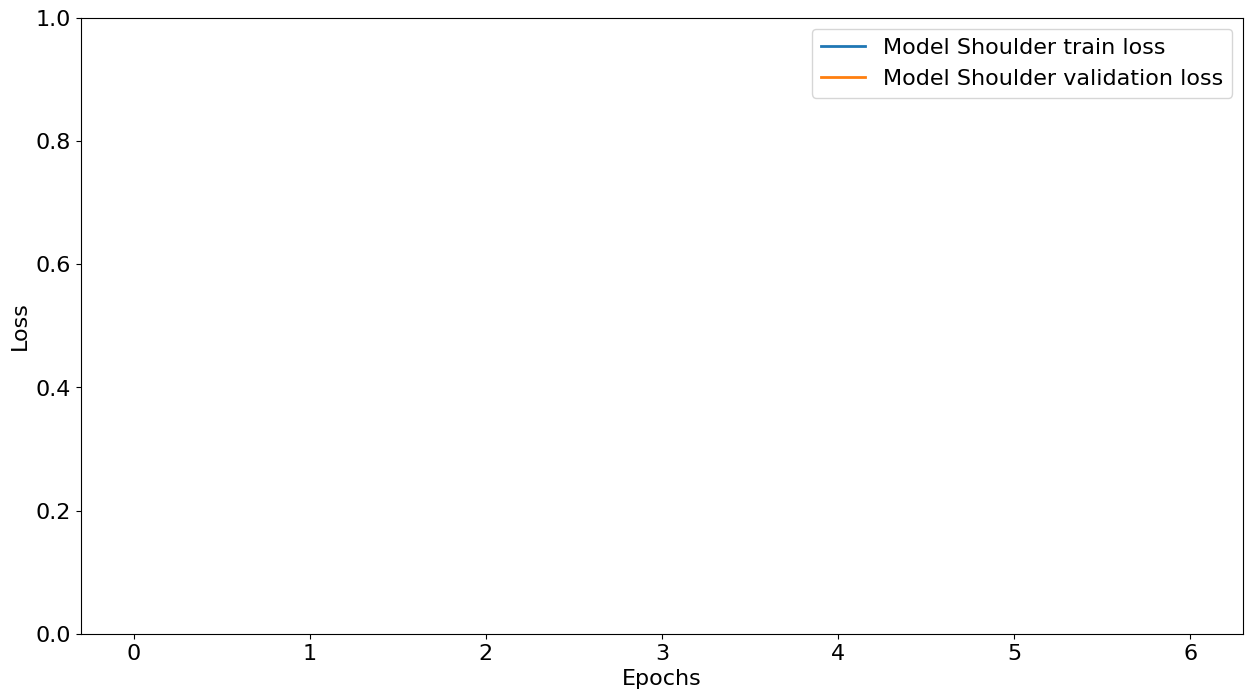

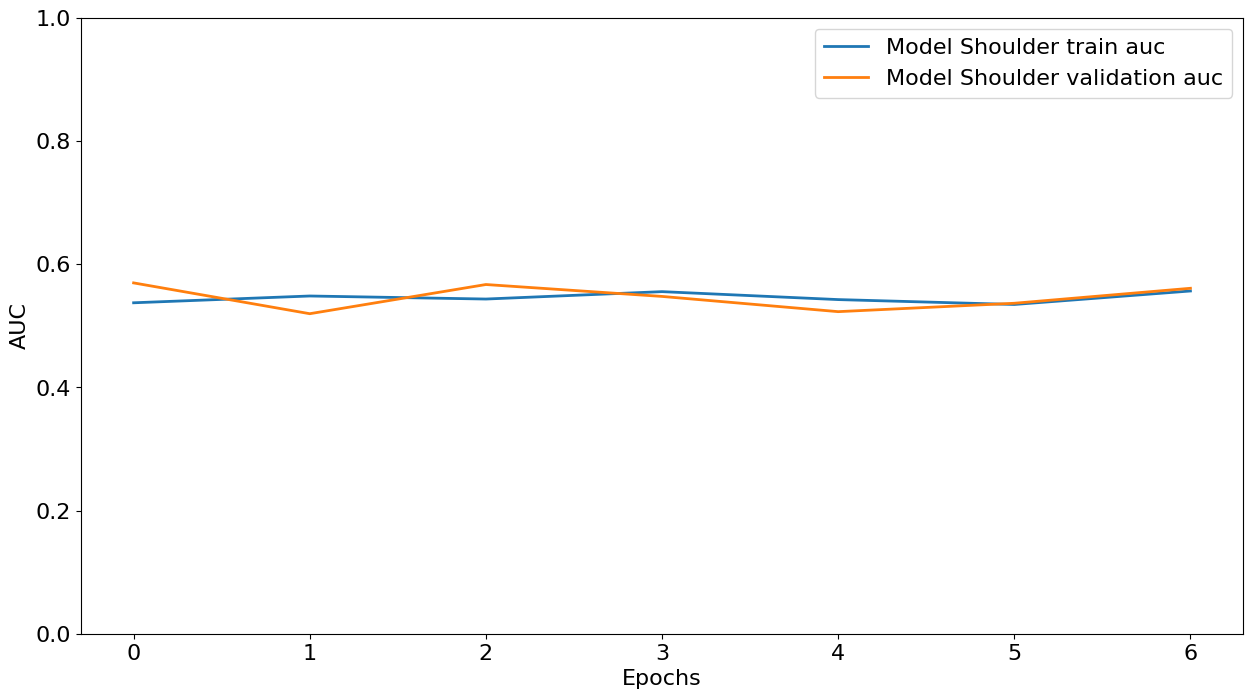

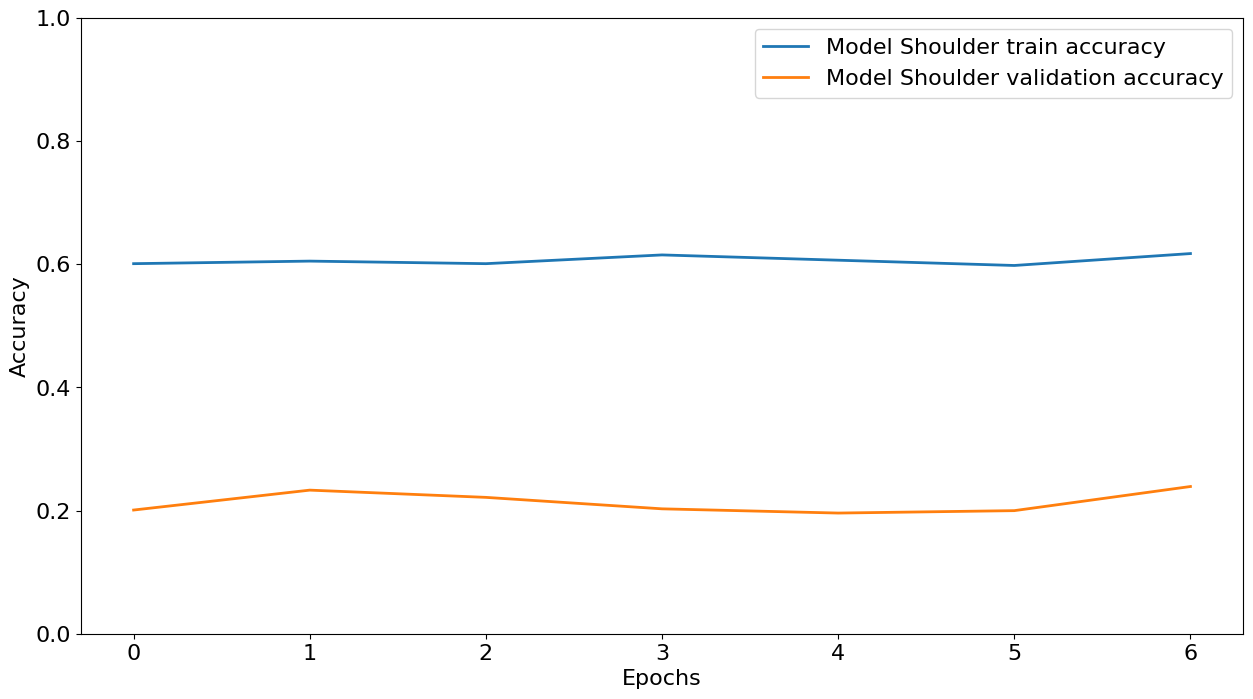

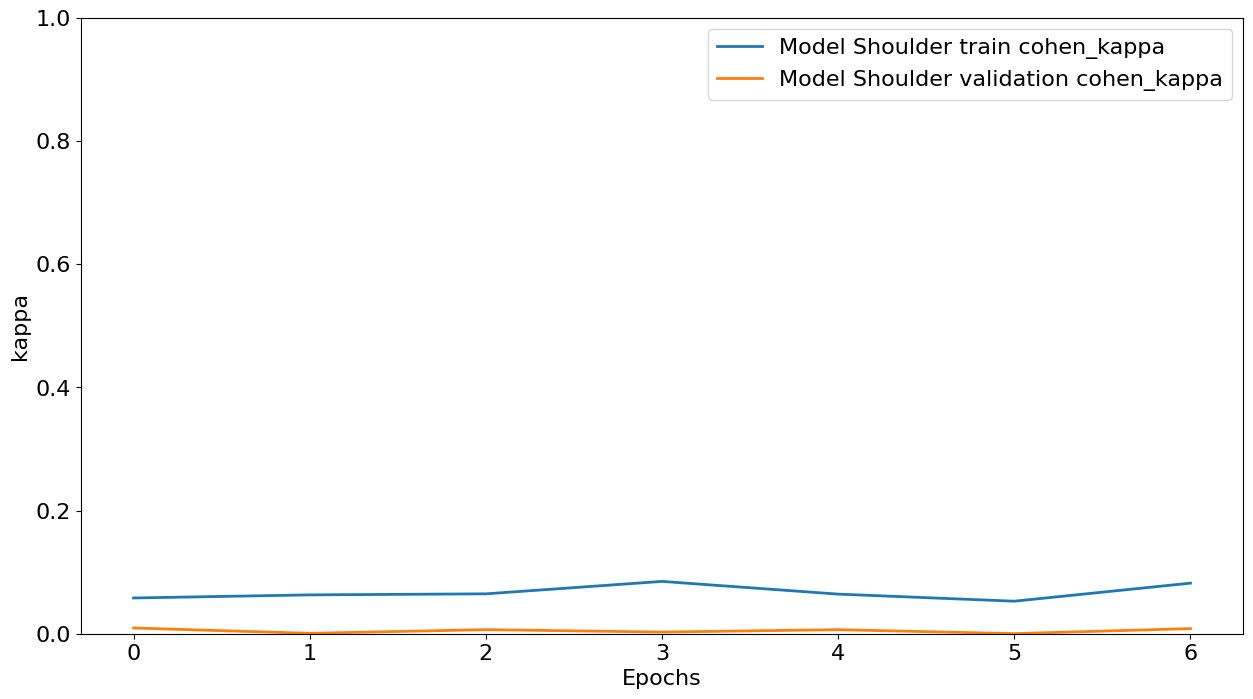

In [121]:
model_eval = model.evaluate(testset_finger)
# clean_up(model=model)
print_results(model_name='Model Shoulder',epochs= EPOCHS, hs = hs_finger, model_eval = model_eval)

### VGG19

In [134]:
def make_vgg_model(
    base_model: tf.keras.applications.vgg19.VGG19,
) -> tf.keras.Model:

    # freeze base model
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.Dense(units=32, activation='relu')(x)  # New Dense layer
    output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[metrics()],
    )

    return model

In [135]:
vgg = tf.keras.applications.vgg19.VGG19(
    include_top=False,  # do not include the fully-connected layer at the top of the network
    weights="imagenet",
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    pooling="max",  # pooling mode for feature extraction
    classes=2,
)

80134624/80134624 [==============================] - 33s 0us/step


In [136]:
model = make_vgg_model(base_model=vgg)

### Pre Trained weights

In [145]:
# not train the weights
vgg.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        1e-4
    ), 
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics()],
)

In [146]:
history = model.fit(
    trainset,
    epochs=20,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_plateau]
) 

Epoch 1/20


2024-03-26 19:05:07.263591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


461/461 [==============================] - 396s 855ms/step - loss: 70987685888.0000 - auc: 0.5018 - accuracy: 0.5191 - cohen_kappa: 0.0036 - f1_score: 0.4089 - val_loss: 32738480128.0000 - val_auc: 0.5000 - val_accuracy: 0.6083 - val_cohen_kappa: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
461/461 [==============================] - 389s 843ms/step - loss: 64653651968.0000 - auc: 0.5025 - accuracy: 0.5203 - cohen_kappa: 0.0050 - f1_score: 0.4084 - val_loss: 165125210112.0000 - val_auc: 0.5000 - val_accuracy: 0.6083 - val_cohen_kappa: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
461/461 [==============================] - 396s 859ms/step - loss: 48993808384.0000 - auc: 0.5040 - accuracy: 0.5219 - cohen_kappa: 0.0080 - f1_score: 0.4099 - val_loss: 40604291072.0000 - val_auc: 0.5000 - val_accuracy: 0.3917 - val_cohen_kappa: 0.0000e+00 - val_f1_score: 0.5629 - lr: 0.0010
Epoch 4/20
461/461 [==============================] - 395s 856ms/step - loss: 585542041

KeyboardInterrupt: 

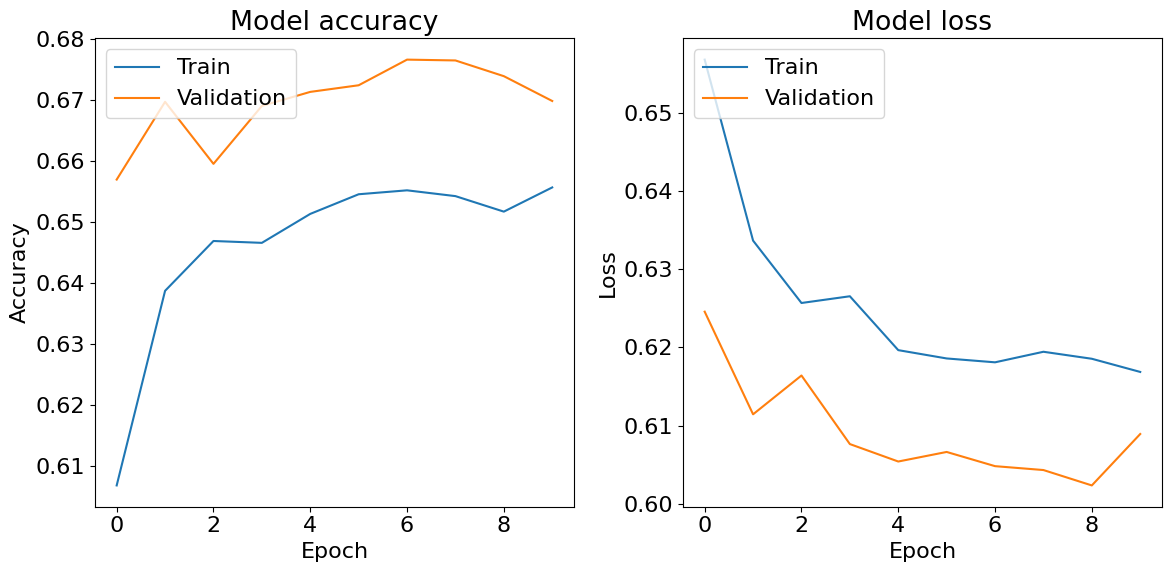

In [139]:
plot_training_curves(history)

9/9 [==============================] - 7s 674ms/step - loss: 0.6745 - auc: 0.6106 - accuracy: 0.5808 - cohen_kappa: 0.1602 - f1_score: 0.5479
Train Loss     : 0.61685
Validation Loss: 0.60892
Test Loss      : 0.67451
---
Train AUC     : 0.68639
Validation AUC: 0.69852
Test AUC      : 0.61062
---
Train Accuracy     : 0.65569
Validation Accuracy: 0.66988
Test Accuracy      : 0.58082
---
Train Kappa     : 0.24035
Validation Kappa: 0.27207
Test Kappa      : 0.16024


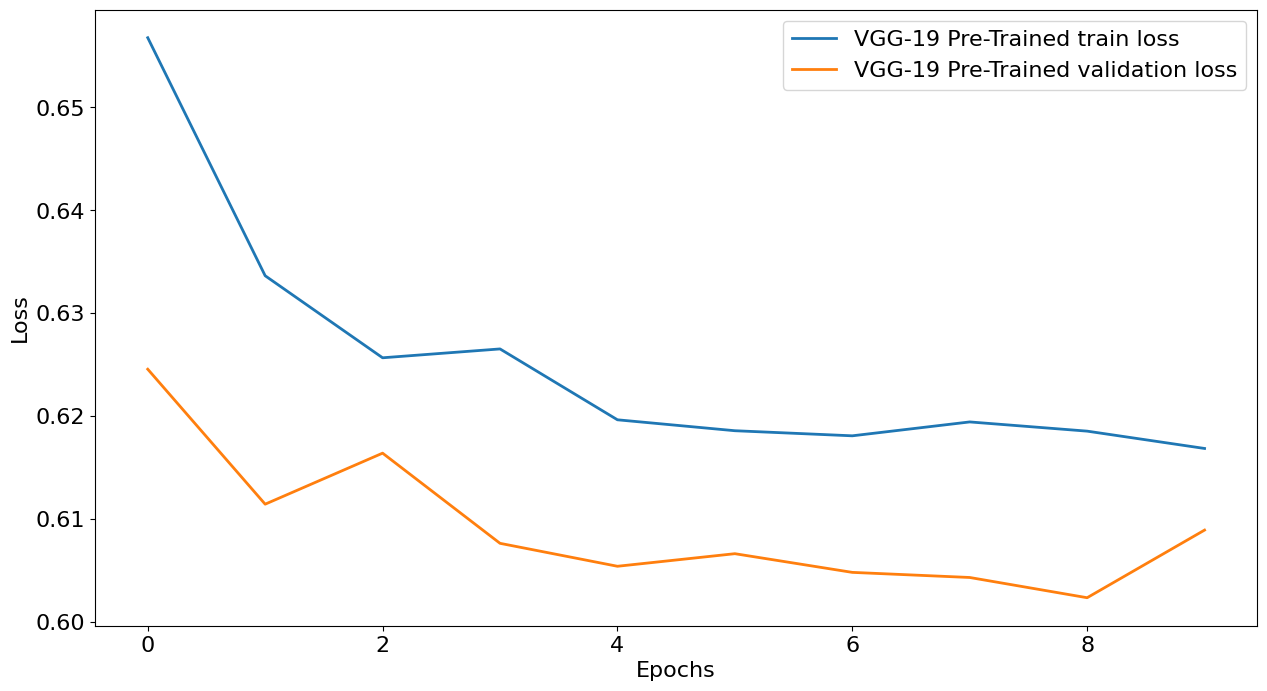

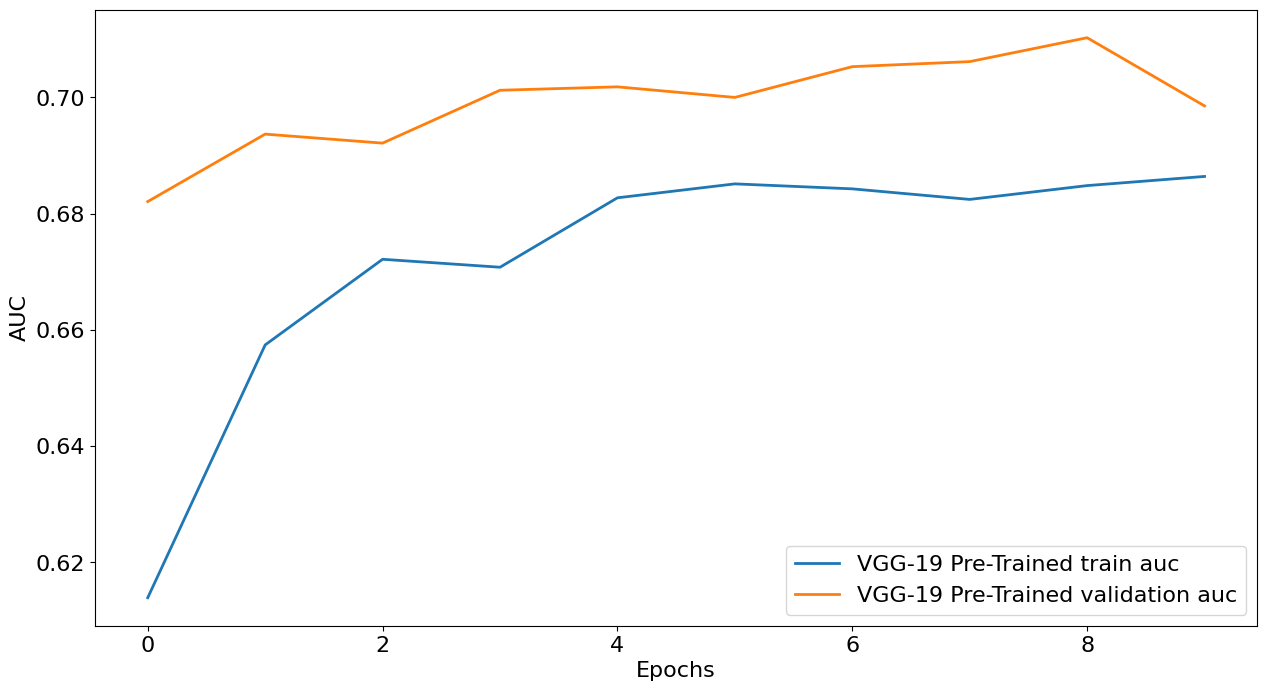

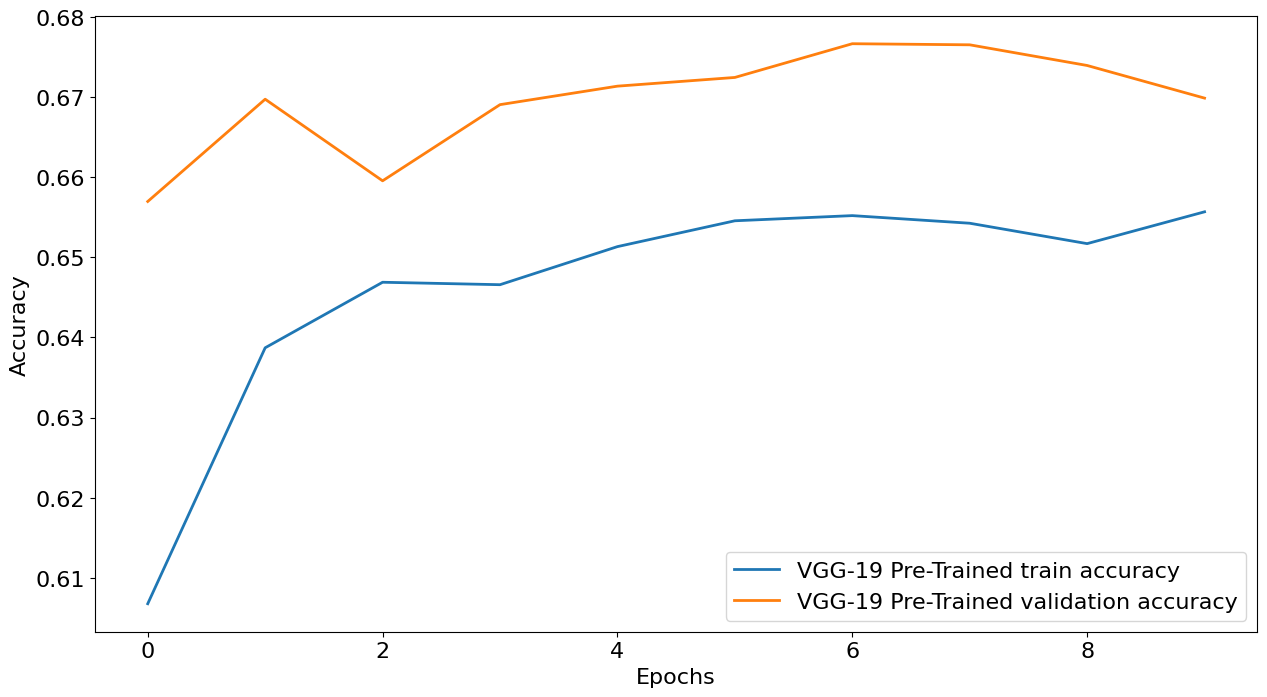

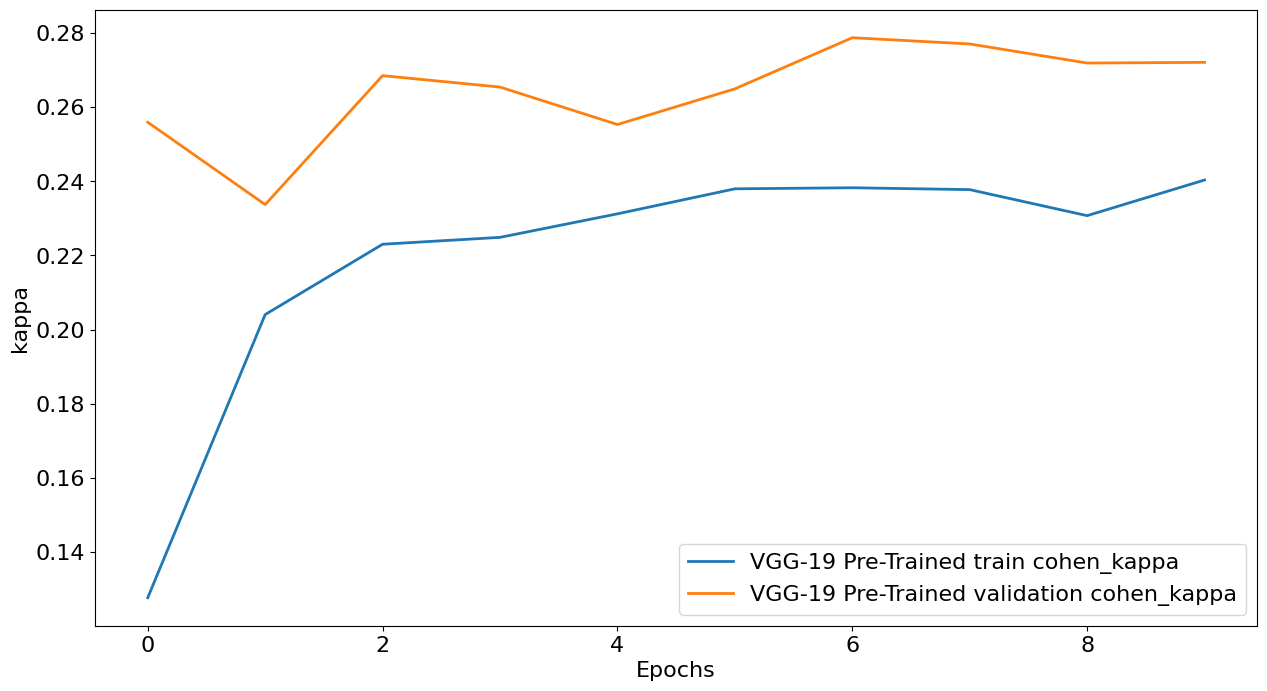

In [141]:
model_eval = model.evaluate(testset)
# clean_up(model=model)
print_results(model_name='VGG-19 Pre-Trained',epochs= EPOCHS, hs = history, model_eval = model_eval)

### Trainable weights

In [142]:
# train the weights
vgg.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(
        1e-3
    ),  # we need small learning rate to avoid catastrophic forgetting
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics()]
)

In [143]:
history_tr = model.fit(
    trainset,
    epochs=20,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_plateau]
) 

Epoch 1/20
461/461 [==============================] - 1512s 3s/step - loss: 65421230080.0000 - auc: 0.4963 - accuracy: 0.5062 - cohen_kappa: -0.0070 - f1_score: 0.4226 - val_loss: 52066033664.0000 - val_auc: 0.5000 - val_accuracy: 0.6083 - val_cohen_kappa: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
  3/461 [..............................] - ETA: 13:32 - loss: 86039199744.0000 - auc: 0.4433 - accuracy: 0.4444 - cohen_kappa: -0.1120 - f1_score: 0.4094

KeyboardInterrupt: 

In [ ]:
plot_training_curves(history_tr)

In [144]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 32)                16416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20040833 (76.45 MB)
Trainable params: 20040833 (76.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
